# Protein conformational space exploration (CSE) using basins trajectories and a Transformer Neural Network with text-to-text translation 

**Packages required:**
    
* MDAnalysis
* MDAnalysisData
* matplotlib
* numpy
* sklearn
* tensorflow
* Bio
* nglview
* pytraj

In [1]:
import warnings
# avoid excessive warning messages to make the notebook nicer
warnings.filterwarnings('ignore')
# warnings.filterwarnings("ignore", category=DeprecationWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import os
import subprocess
import random
import MDAnalysis as mda
from MDAnalysis.tests.datafiles import GRO, XTC
from MDAnalysis.analysis import dihedrals, rms, align
import MDAnalysisData as mda_data
from MDAnalysisData import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from numpy import savetxt,loadtxt
import sklearn as skl
from sklearn import cluster, mixture
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Layer,Dropout,Dense,Bidirectional
from tensorflow.keras.layers import GRU,LSTM,Embedding,MultiHeadAttention
from tensorflow.keras.layers import LayerNormalization,Conv1D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model
from tensorflow.python.client import device_lib
import nglview as nv
import Bio as bio
from Bio.SeqUtils import seq1, seq3
from itertools import chain, islice
import pytraj as pt
import h5py

import modeller as modl
from modeller import *
from modeller.automodel import *    # Load the AutoModel class
from modeller.scripts import complete_pdb
from modeller.optimizers import conjugate_gradients, molecular_dynamics, actions

print("mda version = {}".format(mda.__version__))
print("mda data version = {}".format(mda_data.__version__))
print("plt version = {}".format(matplotlib.__version__))
print("np version = {}".format(np.__version__))
print("skl version = {}".format(skl.__version__))
print("tf version = {}".format(tf.__version__))
print("bio version = {}".format(bio.__version__))
print("nglview version = {}".format(nv.__version__))
print("pytraj version = {}".format(pt.__version__))
print("modeller version = {}\n".format(modl.__version__))

%matplotlib inline
%load_ext autoreload
%autoreload 2

/Users/dgatti/opt/anaconda3/envs/ana_md/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")
/Users/dgatti/opt/anaconda3/envs/ana_md/lib/python3.9/site-packages/MDAnalysis/coordinates/TRJ.py:1209: DeprecationWarning: Please use `netcdf_file` from the `scipy.io` namespace, the `scipy.io.netcdf` namespace is deprecated.
  class NCDFPicklable(scipy.io.netcdf.netcdf_file):


mda version = 2.0.0
mda data version = 0.8.1
plt version = 3.5.1
np version = 1.22.2
skl version = 1.0.2
tf version = 2.8.0
bio version = 1.78
nglview version = 3.0.3
pytraj version = 2.0.6
modeller version = 10.2



## Loading files

### Equilibrium adk trajectory

The file we work with here features adenylate kinase (AdK), a small protein of 214 residues. This is a long MD trajectory with 4187 frames covering over 1 $\mu s$. We will ignore solvent molecules. The variable 'protein' contains all the protein atoms in the MD.

In [3]:
# adk = datasets.fetch_adk_equilibrium()

# print(adk.DESCR)
# print(adk.topology)
# print(adk.trajectory)

In [4]:
# u_equil = mda.Universe(adk.topology, adk.trajectory)

# n_frames = len(u_equil.trajectory)
# print(f'There are {n_frames} frames in the trajectory')

# # Atom selection
# protein = u_equil.select_atoms('protein')
# print(f'There are {len(protein.residues)} protein residues in each frame')

### Multiple adk transition trajectories 

The file we work with here also feature adenylate kinase (AdK), but it is an ensemble of shorter trajectories, each containing a conformational transition. 

In [5]:
adk_trans = datasets.fetch_adk_transitions_DIMS()

print(adk_trans.DESCR)
print(adk_trans.topology) 

.. -*- coding: utf-8 -*-

.. _`adk-transitions-DIMS-dataset`:

AdK DIMS transitions ensemble dataset

The macromolecular conformational transition between the closed
conformation of apo-adenylate kinase from E. coli (EcAdK) to the open
conformation was sampled with two methods: (1) dynamic importance
sampling molecular dynamics (DIMS MD) [Perilla2009]_, and (2)
Framework Rigidity Optimized Dynamics Algorithm (FRODA)
[Farrell2010]_. Each ensemble of independently generated paths
contains 200 trajectories in the CHARMM DCD format.

This data set contains the **DIMS** ensemble.

DIMS AdK (implicit solvent) with dynamic importance sampling MD from
closed (1AKE) to open (4AKE). CHARMM 22 force field. Topology file:
adk4ake.psf


Notes
-----

Data set characteristics:

 :size: 757 MB
 :number of trajectories:  200	
 :number of frames:  varies
 :number of atoms: 3341
 :creator: Sean L. Seyler
 :URL:  `https://doi.org/10.6084/m9.figshare.7165306.v2 <https://doi.org/10.6084/m9.figshare.7165306.

In [6]:
# Here we examine the entire ensemble of trajectories 
n_trj = len(adk_trans.trajectories)
all_trj_nframes = []

for i,trajectory in enumerate(adk_trans.trajectories):
    u = mda.Universe(adk_trans.topology, trajectory)
    single_trj_nframes = len(u.trajectory)
    all_trj_nframes.append(single_trj_nframes)

all_trj_nframes = np.array(all_trj_nframes)

print(f'Number of trajectories in the ensemble: {n_trj}')
print(f'Number of frames in each trajectory of the ensemble:')
print(*all_trj_nframes,'\n')

Number of trajectories in the ensemble: 200
Number of frames in each trajectory of the ensemble:
97 97 98 95 100 98 97 97 96 99 96 97 98 97 107 96 99 100 99 100 99 97 96 98 98 95 98 97 100 99 98 100 100 102 102 94 97 96 102 99 98 96 100 100 99 100 100 103 96 100 101 100 101 100 99 103 103 101 93 105 95 100 103 102 103 101 98 96 101 99 95 96 98 97 94 100 102 98 102 97 99 98 96 96 97 100 95 99 92 93 101 97 93 98 96 103 92 100 96 103 98 100 91 96 98 94 97 102 98 102 100 94 94 96 94 98 101 101 102 100 100 98 104 96 94 99 101 101 97 95 101 96 97 95 102 98 99 102 94 98 96 98 98 100 101 98 95 99 100 97 100 99 93 98 98 97 96 97 100 103 106 99 98 102 105 101 99 98 100 93 101 103 101 96 95 98 98 100 99 102 99 92 94 98 102 96 101 98 101 100 96 97 96 97 99 98 102 102 94 100 



### Validation set

In [7]:
# Here we select the first two trajectories of the ensemble as the validation and test sets, respectively. 
# Later on we will loop through the other trajectories to train the NN.
u_val = mda.Universe(adk_trans.topology, adk_trans.trajectories[0])
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
u_test = mda.Universe(adk_trans.topology, adk_trans.trajectories[1])
print(f'Number of frames in the test set: {len(u_test.trajectory)}')

Number of frames in the validation set: 97
Number of frames in the test set: 97


In [8]:
# Here we use the validation set to view the conformational transition 
view = nv.show_mdanalysis(u_val)
view.center()
view

NGLWidget(max_frame=96)

In [9]:
# Here we use the validation set to get information about the protein
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
protein = u_val.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')

There are 97 frames in the trajectory
There are 214 protein residues in each frame


In [10]:
# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(protein.residues.resnames):
    prot_sequence_tlc += res
print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')


Protein sequence in 3 letter code:
METARGILEILELEULEUGLYALAPROGLYALAGLYLYSGLYTHRGLNALAGLNPHEILEMETGLULYSTYRGLYILEPROGLNILESERTHRGLYASPMETLEUARGALAALAVALLYSSERGLYSERGLULEUGLYLYSGLNALALYSASPILEMETASPALAGLYLYSLEUVALTHRASPGLULEUVALILEALALEUVALLYSGLUARGILEALAGLNGLUASPCYSARGASNGLYPHELEULEUASPGLYPHEPROARGTHRILEPROGLNALAASPALAMETLYSGLUALAGLYILEASNVALASPTYRVALLEUGLUPHEASPVALPROASPGLULEUILEVALASPARGILEVALGLYARGARGVALHSDALAPROSERGLYARGVALTYRHSDVALLYSPHEASNPROPROLYSVALGLUGLYLYSASPASPVALTHRGLYGLUGLULEUTHRTHRARGLYSASPASPGLNGLUGLUTHRVALARGLYSARGLEUVALGLUTYRHSDGLNMETTHRALAPROLEUILEGLYTYRTYRSERLYSGLUALAGLUALAGLYASNTHRLYSTYRALALYSVALASPGLYTHRLYSPROVALALAGLUVALARGALAASPLEUGLULYSILELEUGLY

Protein sequence in split 3 letter code:
['MET', 'ARG', 'ILE', 'ILE', 'LEU', 'LEU', 'GLY', 'ALA', 'PRO', 'GLY', 'ALA', 'GLY', 'LYS', 'GLY', 'THR', 'GLN', 'ALA', 'GLN', 'PHE', 'ILE', 'MET', 'GLU', 'LYS', 'TYR', 'GLY', 'ILE', 'PRO', 'GLN', 'ILE', 'SER', 'THR', 'GLY', 'ASP', 'MET', 'LEU', 'ARG', 'ALA', 'ALA', 'VAL', 'LYS',

In [11]:
# function to get unique values in a list
def unique(list): 
    unique_list = []
    for x in list:
        if x not in unique_list:
            unique_list.append(x)        
    return unique_list

In [12]:
# Unique amino acids in the protein 
unique_aa = unique(split_prot_sequence_tlc)
# print(unique_aa)

# Table used to convert each type of aa into a number
aa_to_number_table = []
split_prot_sequence_as_type = np.zeros((214,))
for i,aa in enumerate(unique_aa):
    aa_to_number_table.append((aa,i))
#     print(aa)
    ind = [res == aa for res in split_prot_sequence_tlc]
    split_prot_sequence_as_type[ind] = i

# Protein sequence as numbers corresponding to different aa's 
# (used later on in the PosEmbedding function)
split_prot_sequence_as_type = split_prot_sequence_as_type.astype('int32').tolist()    
print(f'AA to NUMBER table:\n{aa_to_number_table}\n')
print(f'Protein sequence as aa type:\n{split_prot_sequence_as_type}')
    

AA to NUMBER table:
[('MET', 0), ('ARG', 1), ('ILE', 2), ('LEU', 3), ('GLY', 4), ('ALA', 5), ('PRO', 6), ('LYS', 7), ('THR', 8), ('GLN', 9), ('PHE', 10), ('GLU', 11), ('TYR', 12), ('SER', 13), ('ASP', 14), ('VAL', 15), ('CYS', 16), ('ASN', 17), ('HSD', 18)]

Protein sequence as aa type:
[0, 1, 2, 2, 3, 3, 4, 5, 6, 4, 5, 4, 7, 4, 8, 9, 5, 9, 10, 2, 0, 11, 7, 12, 4, 2, 6, 9, 2, 13, 8, 4, 14, 0, 3, 1, 5, 5, 15, 7, 13, 4, 13, 11, 3, 4, 7, 9, 5, 7, 14, 2, 0, 14, 5, 4, 7, 3, 15, 8, 14, 11, 3, 15, 2, 5, 3, 15, 7, 11, 1, 2, 5, 9, 11, 14, 16, 1, 17, 4, 10, 3, 3, 14, 4, 10, 6, 1, 8, 2, 6, 9, 5, 14, 5, 0, 7, 11, 5, 4, 2, 17, 15, 14, 12, 15, 3, 11, 10, 14, 15, 6, 14, 11, 3, 2, 15, 14, 1, 2, 15, 4, 1, 1, 15, 18, 5, 6, 13, 4, 1, 15, 12, 18, 15, 7, 10, 17, 6, 6, 7, 15, 11, 4, 7, 14, 14, 15, 8, 4, 11, 11, 3, 8, 8, 1, 7, 14, 14, 9, 11, 11, 8, 15, 1, 7, 1, 3, 15, 11, 12, 18, 9, 0, 8, 5, 6, 3, 2, 4, 12, 12, 13, 7, 11, 5, 11, 5, 4, 17, 8, 7, 12, 5, 7, 15, 14, 4, 8, 7, 6, 15, 5, 11, 15, 1, 5, 14, 3, 11, 7,

## Ramachandran analysis

The `Ramachandran` class calculates the $\phi$ and $\psi$ angles of the selected residues over the course of a trajectory, saving it into `results.angles`. If residues are given that do not contain a $\phi$ and $\psi$ angle, they are omitted from the results. For example, the angles returned are from every residue in the protein *except* the first and last, for which a $\phi$ angle and a $\psi$ angle do not exist, respectively.

<img src="dihedral.png" style="width:400px;height:200px;">

The returned `results.angles` are in the shape (`n_frames`, `n_residues`, 2) where the last dimension holds the $\phi$ and $\psi$ angle.

`Ramachandran.plot()` plots the data from each time step onto a standard Ramachandran plot. Any keyword arguments (except `ax` and `ref`) are passed to `matplotlib.axes.Axes.scatter` to modify the plot. Setting `ref=True`, plots areas that show the allowed (dark blue) and marginally allowed (lighter blue) regions.

Ramachandran angles array shape: (97, 212, 2)


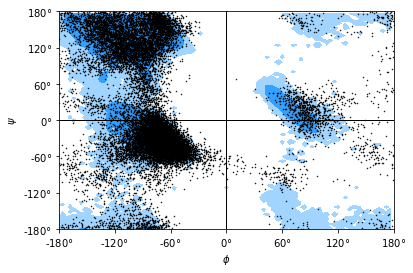

In [13]:
# Ramachandran angles for all the residues in protein. 
# To select a range of frames use .run(startframe,endframe+1)
# The 'protein' selection still refers here to the validation trj
rama = dihedrals.Ramachandran(protein).run()
rama.plot(color='black', marker='.', s=1, ref=True)
trj_phipsi = rama.results.angles
print(f'Ramachandran angles array shape: {trj_phipsi.shape}')

### Conversion of the trajectory into a lists of 4 symbols/frame.

Using simple selection of 4 attraction basins may ignore the actual distributions of angles during the dynamic. The function phipsi_to_basin offers the option to cluster the angles by k-means. We can shift the phi angles in order to obtain a better selection of basins.

In [14]:
def phipsi_to_basin(angles,phi_shift=-120.,cluster=False,n_clusters=4,plot=True):
    
    # Here, we reshape the sequence of frames so that the entire trajectory fits into 
    # a single 2D array for clustering
    shapes = angles.shape
    angles = np.reshape(angles,(shapes[0]*shapes[1],shapes[2]),order='C')

    # Shift in phi angles to obtain clean basins
    for value in angles:
        if value[1]<phi_shift:
            value[1] += 360.    

    init_centroids = np.array([[-100.,150],[-100.,-50.],[100.,-50.],[100.,150.]])
    kmeans = KMeans(n_clusters, 
                    init=init_centroids,
                    random_state=123,
                    algorithm='full').fit(angles)
    centroids = kmeans.cluster_centers_
    # score = kmeans.score(angles)
    
    if cluster:
        preds = kmeans.labels_
    else:
        preds = []
        for phipsi in angles:
            if phipsi[0]<=25. and phipsi[1]>70.:
                preds.append(0)
            elif phipsi[0]<=25. and phipsi[1]<=70.:
                preds.append(1)
            elif phipsi[0]>25. and phipsi[1]<=70.:
                preds.append(2)
            elif phipsi[0]>25. and phipsi[1]>70:
                preds.append(3)
        preds = np.array(preds) 
        
    if plot:
        x = [phipsi[0] for phipsi in angles]
        y = [phipsi[1] for phipsi in angles]

        # The scatter plot has markers colored by the basin cluster
        fig, (ax1) = plt.subplots(1,1)
        fig.set_figheight(5)
        fig.set_figwidth(7)
        fig.suptitle('Ramachandran plot with Basins predictions')
        scatterplot = ax1.scatter(x,y,s=1,c=preds)
        ax1.set_xticklabels(['$-200^{\circ}$','$-150^{\circ}$','$-100^{\circ}$','$-50^{\circ}$',\
                             '$0^{\circ}$','$50^{\circ}$','$100^{\circ}$','$150^{\circ}$'],fontsize=13)
        ax1.set_yticklabels(['$-150^{\circ}$','$-100^{\circ}$','$-50^{\circ}$',\
                             '$0^{\circ}$','$50^{\circ}$','$100^{\circ}$',\
                             '$150^{\circ}$','$200^{\circ}$','$250^{\circ}$'],fontsize=13)
        ax1.set_ylabel("$\psi$",fontsize=14)
        ax1.set_xlabel("$\phi$",fontsize=14)
        ax1.grid()

        # produce a legend with the unique colors from the scatter
        legend = ax1.legend(*scatterplot.legend_elements(),
                            loc="best", title="Classes")
        ax1.add_artist(legend)
        ax1.legend()
                
    basins = np.reshape(preds,(shapes[0],shapes[1]))
    angles = np.reshape(angles,(shapes[0],shapes[1],shapes[2]))            
        
    return angles,basins,centroids

In [15]:
print(trj_phipsi.shape)

(97, 212, 2)


### Validation Basins datasets
First we use as validation set only the first trajectory to obtain a nice image of the clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


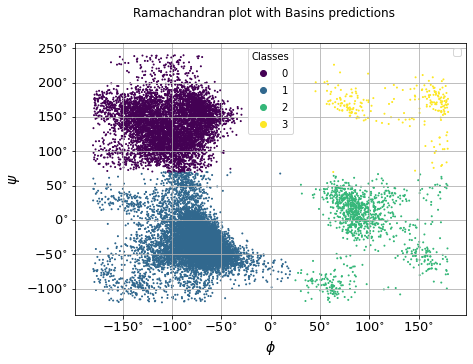

In [16]:
val_angles,val_basins,val_centroids = phipsi_to_basin(trj_phipsi,phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=True)

In [17]:
val_basins.shape

(97, 212)

In [18]:
print(f'Ramachandran centroids\n {val_centroids}')
print(f'Basin trj dimensions: {val_basins.shape}')
print(f'Basin trj: {val_basins}')

Ramachandran centroids
 [[-102.97911129  137.48311941]
 [ -73.80445381  -35.30650969]
 [  94.83474066   -3.92823148]
 [ 127.8071452   166.7574127 ]]
Basin trj dimensions: (97, 212)
Basin trj: [[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


In [19]:
print(*val_basins[0])

0 0 0 0 0 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [20]:
print(*val_basins[-47])

0 0 0 0 0 3 0 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 3 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [21]:
print(*val_basins[-1])

0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


#### Select a validation:test:training split at 20:20:60
In preparation for training we select a more traditional split between validation, test, and training set.

In [22]:
u_val = mda.Universe(adk_trans.topology, adk_trans.trajectories[0:40])
print(f'Number of frames in the validation set: {len(u_val.trajectory)}')
u_test = mda.Universe(adk_trans.topology, adk_trans.trajectories[40:80])
print(f'Number of frames in the test set: {len(u_test.trajectory)}')

Number of frames in the validation set: 3930
Number of frames in the test set: 3975


In [23]:
# Here we use the larger validation set to get information about the protein
n_frames = len(u_val.trajectory)
print(f'There are {n_frames} frames in the trajectory')

# Atom selection
protein = u_val.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')

There are 3930 frames in the trajectory
There are 214 protein residues in each frame


In [24]:
# Ramachandran angles for all the residues in protein. 
# To select a range of frames use .run(startframe,endframe+1)
# The 'protein' selection still refers here to the validation trj
rama = dihedrals.Ramachandran(protein).run()
# rama.plot(color='black', marker='.', s=1, ref=True)
trj_phipsi = rama.results.angles
print(f'Ramachandran angles array shape: {trj_phipsi.shape}')

Ramachandran angles array shape: (3930, 212, 2)


In [25]:
val_angles,val_basins,val_centroids = phipsi_to_basin(trj_phipsi,phi_shift=-120.,
                                                      cluster=False,
                                                      n_clusters=4,
                                                      plot=False)

In [26]:
print(*val_basins[0])

0 0 0 0 0 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [27]:
print(*val_basins[1000])

0 0 0 0 0 3 0 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [28]:
print(*val_basins[2500])

0 0 0 0 0 3 0 0 2 0 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1


In [29]:
print(*val_basins[3800])

0 0 0 0 0 3 0 0 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


Looks good: we can now use the predictions to convert the trj into an array of frames 
with each frame being an array of 4 symbols, one for each basin of attraction. First and last residues do not have phi-psi angles, so we only have 212 basins for the 214 residues of Adk.

### Dataset serving batches of inputs and targets to the Transformer

Starting from the initial basins dataset, we eliminate consecutive identical  frames and create 3 new datasets each with different padding:
* an input dataset for the encoder with final padding [6 6 6]
* an input dataset for the decoder with initial padding [4] (where 4 is the 'sequence start' signal) and final padding [5 6] (where 5 is the 'sequence end' signal). 
* a target dataset for the transformer with final padding [5 6 6]

The encoder input is the last know frame. The decoder input is the same sequence as the transformer target (the next frame to predict). However they are padded in a different way, as the decoder input must start from a generic 'sequence start' signal (in this case, number 4) to predict the 1st basin of the target, and stop predicting when it encounters a 'sequence end' signal (in this case, number 5). 


In [30]:
# Function to eliminate consecutive identical frames or 
# to skip frames in the basin trajectory
def reduce_basins(basins,ncycles,nskip):

    if ncycles == 0 and nskip > 1:
        trj = np.copy(basins)
        reduced_basins = np.array(trj[0::nskip,:])
    elif ncycles > 0 and nskip == 0:
        red_cycles = ncycles
        trj = np.copy(basins)

        for red_cycle in range(red_cycles):

            first_frame = np.array([trj[0]])
            # print(first_frame.shape,type(first_frame))

            count = 0
            reduced_trj = np.copy(first_frame)
            for i,frame in enumerate(trj):
                frame = np.array([frame])

                if i == 0:
                    previous_frame = first_frame

                if np.array_equal(previous_frame,frame):
                    previous_frame = frame
                    continue
                else:
                    count += 1
                    reduced_trj = np.append(reduced_trj,frame,axis=0)
                    previous_frame = frame

            # print(trj.shape)
            # print(count,reduced_trj.shape)
            trj = reduced_trj

        reduced_basins = trj
    
    return reduced_basins
  

# Function to pre-process basin trajectories for text_to_text_translation
def preprocess_basins(basins,reduce=True,reduce_cycles=2,skip_frames=0):
    if reduce:
        basins = reduce_basins(basins,reduce_cycles,skip_frames)
        
    n_frames = len(basins) - 1 
        
    # Encoder input. This set starts with the first frame and end 
    # with the next to last. The final padding [6,6,6] contains only number 6, 
    # which does not define a 'start', a 'basin', or an 'end'.
    inputs1 = np.zeros((n_frames,215)).astype('int32')
    for i,basin_vec in enumerate(basins[:-1]):
        basin_vec = np.append(basin_vec,np.array([6,6,6])) 
        inputs1[i] = basin_vec

    # Decoder input. This set start with the second frame and ends with the last. 
    # The initial padding [4] shifts the sequence by 1 position forward with 
    # respect to the target sequence. The final padding [5,6] adds an 'end' signal, 
    # and a non descriptive [6].
    inputs2 = np.zeros((n_frames,215)).astype('int32')
    for i,basin_vec in enumerate(basins[1:]):
        basin_vec = np.concatenate((np.array([4]),basin_vec,np.array([5,6]))) 
        inputs2[i] = basin_vec    

    # Transformer target. This set start with the second frame and ends with the last. 
    # It has the same protein sequence of the decoder input, 
    # without an initial 'start' signal [4], and with a final padding [5,6,6] that 
    # contains one 'end' signal [5] and two non-descriptive [6].    
    targets = np.zeros((n_frames,215)).astype('int32')
    for i,basin_vec in enumerate(basins[1:]):
        basin_vec = np.append(basin_vec,np.array([5,6,6])) 
        targets[i] = basin_vec  
        
    return inputs1,inputs2,targets
    

# Function to format the dataset so that the 1st 2 elements provide inputs 
# and the 3rd element targets. In this case we return a tuple containing a 
# dictionary with two keys for the encoder and decoder inputs, 
# and a target for the transformer
def format_dataset(inputs1,inputs2,targets):
    return ({
            "train1": inputs1,
            "train2": inputs2,
            }, targets)


# Function to make a data.Dataset pipeline to serve batches of basin frames 
# to a Transformer. The number of parallel calls sets the number of cpu cores 
# used for serving data
def dataset_from_basin_trj(basins,reduce=True,reduce_cycles=2,skip_frames=0,
                           batch_size='All',n_cpu=2,shuffle=True,
                           reshuffle=True,n_fetch=1,cache=False):
    
    inputs1,inputs2,targets = preprocess_basins(basins,reduce,reduce_cycles,skip_frames)
    dataset = tf.data.Dataset.from_tensor_slices((inputs1,inputs2,targets))
    if batch_size == 'All':
        batch_size = len(targets)        
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=n_cpu)
    
    # Here we shuffle from a number of elements at least as large as 
    # the number of frames in the dataset and prefetch in memory n_fetch batches 
    # to speed up processing
    
    if shuffle:
        if cache:
            dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle).prefetch(n_fetch).cache()
        else:
            dataset = dataset.shuffle(n_frames+1,reshuffle_each_iteration=reshuffle).prefetch(n_fetch)
    
    return inputs1,inputs2,targets,dataset

### Validation dataset

In [31]:
val_inputs1,val_inputs2,val_targets,val_dataset = dataset_from_basin_trj(val_basins,
                                                                         reduce=True,
                                                                         reduce_cycles=0,
                                                                         skip_frames=6,
                                                                         batch_size='All',
                                                                         n_cpu=2,
                                                                         n_fetch=1)

2022-06-09 10:53:45.603304: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
print(f'Number of batches served: {len(val_dataset)}')
print(f'In each batch we have 3 components:')

for inputs, targets in val_dataset.take(1):
    print(f"inputs['train1'] of shape: {inputs['train1'].shape}")
    print(f"inputs['train2'] of shape: {inputs['train2'].shape}")
    print(f"targets of shape: {targets.shape}")

# Alternative syntaxes to iterate the dataset
# it_dataset = iter(val_dataset)
# print(next(it_dataset)) 

# for i, batch in enumerate(val_dataset):
#     print(batch[0])
#     print(batch[1])    
#     if i >= 1:
#         break

Number of batches served: 1
In each batch we have 3 components:
inputs['train1'] of shape: (654, 215)
inputs['train2'] of shape: (654, 215)
targets of shape: (654, 215)


### Test dataset

In [33]:
n_frames = len(u_test.trajectory)
print(f'There are {n_frames} frames in the trajectory')
protein = u_test.select_atoms('protein')
print(f'There are {len(protein.residues)} protein residues in each frame')
rama = dihedrals.Ramachandran(protein).run()
trj_phipsi = rama.results.angles
test_angles,test_basins,test_centroids = phipsi_to_basin(trj_phipsi,
                                                         phi_shift=-120.,
                                                         cluster=False,
                                                         n_clusters=4,
                                                         plot=False)
test_inputs1,test_inputs2,test_targets,test_dataset = dataset_from_basin_trj(test_basins,
                                                                         reduce=True,
                                                                         reduce_cycles=0,
                                                                         skip_frames=6,
                                                                         batch_size='All',
                                                                         n_cpu=2,
                                                                         n_fetch=1)

print(f'Number of batches served: {len(test_dataset)}')
print(f'In each batch we have 3 components:')

for inputs, targets in test_dataset.take(1):
    print(f"inputs['train1'] of shape: {inputs['train1'].shape}")
    print(f"inputs['train2'] of shape: {inputs['train2'].shape}")
    print(f"targets of shape: {targets.shape}")

There are 3975 frames in the trajectory
There are 214 protein residues in each frame
Number of batches served: 1
In each batch we have 3 components:
inputs['train1'] of shape: (662, 215)
inputs['train2'] of shape: (662, 215)
targets of shape: (662, 215)


### New Layer Classes not included in Keras distribution

In [34]:
# Here we modify the original positional embedding layer from Francois Chollet 
# to allow padding with a specific number and embedding based also on 
# res chemical type

class PosEmbedding(Layer):
    def __init__(self, sequence_length, 
                 input_dim, output_dim, pad_num,
                 sequence_as_type, aa_types,
                 target_front_pad, train_end_pad, target_end_pad,
                 train=True, embed_types=True, pad_types=True, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.type_embedding = layers.Embedding(
            input_dim=aa_types, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.pad_num = pad_num
        self.sequence_as_type = sequence_as_type
        self.aa_types = aa_types       
        self.target_front_pad = target_front_pad
        self.train_end_pad = train_end_pad
        self.target_end_pad = target_end_pad        
        self.train = train
        self.embed_types = embed_types
        self.pad_types = pad_types         
        

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)

        if self.pad_types:    
            if self.train:
                sequence = tf.concat([self.sequence_as_type,
                                      train_end_pad],-1)
            else:
                sequence = tf.concat([target_front_pad,
                                      self.sequence_as_type,
                                      target_end_pad],-1) 
        else:
            sequence = self.sequence_as_type
            sequence = tf.cast(sequence, dtype="int32")
            
        embedded_type = self.type_embedding(sequence)                     
        
        if self.embed_types:
            return embedded_tokens + embedded_positions + embedded_type
        else:
            return embedded_tokens + embedded_positions     

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, self.pad_num)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
            "pad_num": self.pad_num,
            "sequence_as_type": self.sequence_as_type,
            "aa_types": self.aa_types,
            "target_front_pad": self.target_front_pad,
            "train_end_pad": self.train_end_pad,
            "target_end_pad": self.target_end_pad,
            "train": self.train,
            "embed_types": self.embed_types,
            "pad_types": self.pad_types,            
        })
        return config


class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config
    

class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)
    

### Transformer architecture 

In [35]:
# DEVICES

physical_devices_GPU = tf.config.list_physical_devices('GPU') 
print("Num GPUs:", len(physical_devices_GPU))

physical_devices_CPU = tf.config.list_physical_devices('CPU') 
print("Num CPUs:", len(physical_devices_CPU)) 

local_device_protos = device_lib.list_local_devices()
print(local_device_protos)


Num GPUs: 0
Num CPUs: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11478824508961782958
xla_global_id: -1
]


In [36]:
# Text-to-text transformer using dataset pipeline
keras.backend.clear_session()

if "transformer" in globals() or "transformer" in locals():
    del transformer
       
pad_length = 3
train_end_pad = [22,22,22]
target_front_pad = [20]
target_end_pad = [21,22]
sequence_as_type = split_prot_sequence_as_type[1:-1]

# sequence length is the number or Ramachandran tuples as phi-psi angles
sequence_length = trj_phipsi.shape[1]
padded_sequence_length = sequence_length + pad_length

embed_dim = 32
pad_num = 6
classes = pad_num + 1
vocab_size = 7
num_heads = 4
dense_dim = 64
aa_types = 24

# Unflag the following two lines if using multiple GPU's and indent the network definition 
# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():

# ######################### Network definition start ######################

encoder_inputs = keras.Input(shape=(None,), dtype="int32", name='train1')
x = PosEmbedding(padded_sequence_length, vocab_size, embed_dim, pad_num, 
                  sequence_as_type, aa_types, 
                  train_end_pad, target_front_pad, target_end_pad, 
                  train=True, embed_types=True, pad_types=True,
                  name='EncoderEmbedding')(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, 
                                     num_heads, name='Encoder')(x)                             

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name='train2')                             

x = PosEmbedding(padded_sequence_length, vocab_size, embed_dim, pad_num, 
                  sequence_as_type, aa_types, 
                  train_end_pad, target_front_pad, target_end_pad, 
                  train=False, embed_types=True, pad_types=True, 
                  name='DecoderEmbedding')(decoder_inputs) 
x = TransformerDecoder(embed_dim, dense_dim, 
                       num_heads, name='Decoder')(x, encoder_outputs)
x = Dropout(0.5, name='Dropout')(x)
decoder_outputs = Dense(classes, activation="softmax", name='Softmax')(x)

transformer = keras.Model([encoder_inputs,decoder_inputs], decoder_outputs)
transformer.compile(optimizer="rmsprop", 
                    loss="sparse_categorical_crossentropy", 
                    metrics=["accuracy"])

# ######################### Network definition end ####################### 
    
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 train1 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 train2 (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 EncoderEmbedding (PosEmbedding  (None, 215, 32)     7872        ['train1[0][0]']                 
 )                                                                                                
                                                                                                  
 DecoderEmbedding (PosEmbedding  (None, 215, 32)     7872        ['train2[0][0]']             

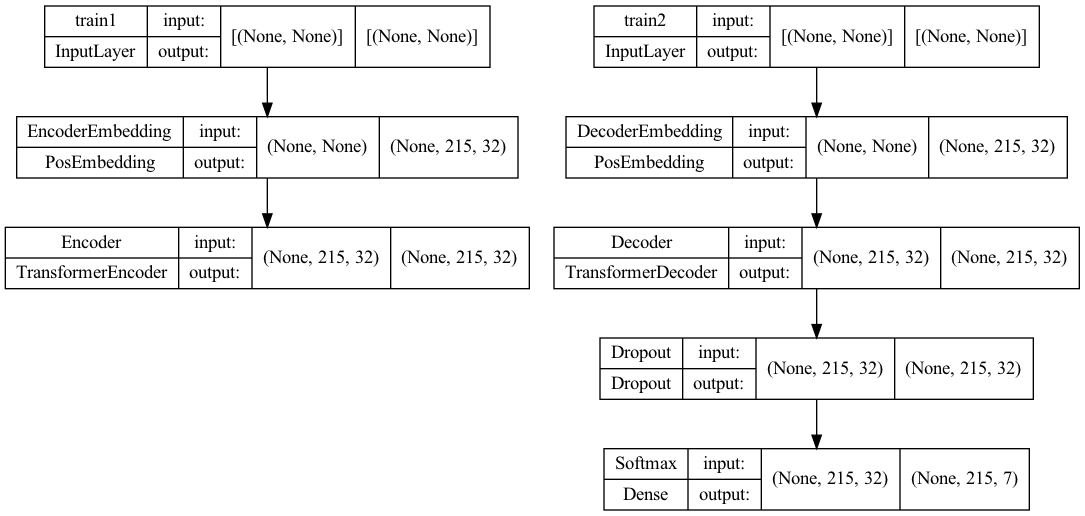

In [37]:
plot_model(transformer, show_shapes=True,\
           show_layer_names=True,\
           to_file='Transformer_v8.0_architecture.png') 

### Training loop.

Here we iterate for 1 epochs trought all the trajectories in the ensemble starting from trajectory index=2, further refining the transformer model. This is what we consider a 'sub-epoch'. In each sub-epoch the training set is the current trajectory from the loop, while the validation set is always the trajectory with index=0. The number of batches served in each sub-epoch is determined by the number chosen for the execution of the dataset_from_basin_trj function. 

The number of true 'epochs' is the number of times we iterate over the entire ensemble. Currently, this loop saves memory, but unfortunately recalculates the rama angles in each epoch. It does not seem to slow down the fit, but in future we may put everything in memory from the start.

If the number of batches in 'dataset_from_basin_trj' is set to 'All', then the entire trajectory is served as a single batch, and the number of 'epochs' corresponds to the traditional definition of 'epoch' for the entire ensemble of trajectories.

In [38]:
# We fit for 10 epochs of 120 subepochs. Each subepoch is a trajectory 
# served as batches of 'batch_size' frames

train_acc = []
val_acc = []

train_loss = []
val_loss = []

sub_epoch = 1
epochs = 10

trj_ind_list = list(range(80,n_trj))

for epoch in range(epochs):
    
    # In every epoch we reshuffle the trajectories
    trj_ind_list_shuffled = random.sample(trj_ind_list,len(trj_ind_list))
    print(f'Shuffled list of trajectories:')
    print(trj_ind_list_shuffled,'\n')
    
    for i in range(len(trj_ind_list_shuffled)):
    # for i,trajectory in enumerate(adk_trans.trajectories[2:]):
        trj_ind = trj_ind_list_shuffled[i]
        # the universe is updated with the next trajectory from the ensemble
        u = mda.Universe(adk_trans.topology, adk_trans.trajectories[trj_ind])
        n_frames = len(u.trajectory)
    #     print(f'There are {n_frames} frames in the trajectory')
        protein = u.select_atoms('protein')
        rama = dihedrals.Ramachandran(protein).run()
        trj_phipsi = rama.results.angles
        _,basins,_ = phipsi_to_basin(trj_phipsi,phi_shift=-120.,
                                     cluster=False,
                                     n_clusters=4,
                                     plot=False)
 
        _,_,_,dataset = dataset_from_basin_trj(basins,
                                               reduce=True,
                                               reduce_cycles=0,
                                               skip_frames=6,
                                               batch_size='All',
                                               n_cpu=2,
                                               n_fetch=1)      

    # Here we train the network by fitting predictions to targets for 100 epochs,
    # and we plot the loss over the epochs
        print(f'Epoch {epoch+1} Trajectory {i+1} [Ensemble Trajectory {trj_ind}]')
        history_transformer = transformer.fit(dataset,
                                              validation_data=val_dataset,
                                              epochs=sub_epoch)

        train_acc.append(history_transformer.history["accuracy"])
        val_acc.append(history_transformer.history["val_accuracy"])
        train_loss.append(history_transformer.history["loss"])
        val_loss.append(history_transformer.history["val_loss"])        

Shuffled list of trajectories:
[92, 185, 144, 121, 168, 148, 197, 178, 195, 106, 90, 113, 85, 160, 198, 143, 107, 89, 102, 156, 192, 128, 170, 154, 117, 146, 184, 109, 152, 134, 132, 189, 199, 186, 196, 173, 177, 142, 182, 126, 164, 96, 181, 159, 88, 119, 138, 111, 115, 161, 95, 108, 149, 130, 122, 183, 94, 193, 105, 83, 82, 110, 125, 91, 165, 188, 93, 98, 145, 147, 124, 176, 191, 127, 123, 118, 114, 166, 151, 157, 80, 81, 120, 187, 163, 167, 174, 87, 129, 100, 190, 84, 150, 135, 99, 158, 137, 112, 97, 155, 169, 133, 131, 141, 86, 103, 140, 101, 179, 175, 136, 153, 171, 104, 162, 172, 139, 116, 180, 194] 

Epoch 1 Trajectory 1 [Ensemble Trajectory 92]
1/1 [==============================] - 17s 17s/step - loss: 2.7343 - accuracy: 0.1801 - val_loss: 1.0169 - val_accuracy: 0.6478
Epoch 1 Trajectory 2 [Ensemble Trajectory 185]
1/1 [==============================] - 8s 8s/step - loss: 1.3384 - accuracy: 0.5991 - val_loss: 0.8329 - val_accuracy: 0.6729
Epoch 1 Trajectory 3 [Ensemble Trajecto

1/1 [==============================] - 9s 9s/step - loss: 0.1285 - accuracy: 0.9720 - val_loss: 0.0817 - val_accuracy: 0.9745
Epoch 1 Trajectory 45 [Ensemble Trajectory 88]
1/1 [==============================] - 12s 12s/step - loss: 0.1111 - accuracy: 0.9729 - val_loss: 0.0809 - val_accuracy: 0.9745
Epoch 1 Trajectory 46 [Ensemble Trajectory 119]
1/1 [==============================] - 10s 10s/step - loss: 0.1432 - accuracy: 0.9688 - val_loss: 0.0818 - val_accuracy: 0.9753
Epoch 1 Trajectory 47 [Ensemble Trajectory 138]
1/1 [==============================] - 8s 8s/step - loss: 0.1307 - accuracy: 0.9685 - val_loss: 0.0886 - val_accuracy: 0.9682
Epoch 1 Trajectory 48 [Ensemble Trajectory 111]
1/1 [==============================] - 7s 7s/step - loss: 0.1314 - accuracy: 0.9688 - val_loss: 0.0897 - val_accuracy: 0.9720
Epoch 1 Trajectory 49 [Ensemble Trajectory 115]
1/1 [==============================] - 8s 8s/step - loss: 0.1380 - accuracy: 0.9676 - val_loss: 0.0909 - val_accuracy: 0.9726
E

1/1 [==============================] - 15s 15s/step - loss: 0.0885 - accuracy: 0.9732 - val_loss: 0.0773 - val_accuracy: 0.9718
Epoch 1 Trajectory 92 [Ensemble Trajectory 84]
1/1 [==============================] - 8s 8s/step - loss: 0.1216 - accuracy: 0.9638 - val_loss: 0.0859 - val_accuracy: 0.9715
Epoch 1 Trajectory 93 [Ensemble Trajectory 150]
1/1 [==============================] - 9s 9s/step - loss: 0.1181 - accuracy: 0.9641 - val_loss: 0.0810 - val_accuracy: 0.9722
Epoch 1 Trajectory 94 [Ensemble Trajectory 135]
1/1 [==============================] - 10s 10s/step - loss: 0.1180 - accuracy: 0.9658 - val_loss: 0.0787 - val_accuracy: 0.9732
Epoch 1 Trajectory 95 [Ensemble Trajectory 99]
1/1 [==============================] - 8s 8s/step - loss: 0.1223 - accuracy: 0.9654 - val_loss: 0.0750 - val_accuracy: 0.9738
Epoch 1 Trajectory 96 [Ensemble Trajectory 158]
1/1 [==============================] - 8s 8s/step - loss: 0.0754 - accuracy: 0.9775 - val_loss: 0.0763 - val_accuracy: 0.9736
Ep

1/1 [==============================] - 7s 7s/step - loss: 0.0990 - accuracy: 0.9702 - val_loss: 0.0679 - val_accuracy: 0.9772
Epoch 2 Trajectory 15 [Ensemble Trajectory 148]
1/1 [==============================] - 8s 8s/step - loss: 0.0824 - accuracy: 0.9740 - val_loss: 0.0689 - val_accuracy: 0.9746
Epoch 2 Trajectory 16 [Ensemble Trajectory 169]
1/1 [==============================] - 6s 6s/step - loss: 0.0656 - accuracy: 0.9794 - val_loss: 0.0694 - val_accuracy: 0.9763
Epoch 2 Trajectory 17 [Ensemble Trajectory 103]
1/1 [==============================] - 6s 6s/step - loss: 0.1213 - accuracy: 0.9685 - val_loss: 0.0758 - val_accuracy: 0.9734
Epoch 2 Trajectory 18 [Ensemble Trajectory 89]
1/1 [==============================] - 6s 6s/step - loss: 0.0804 - accuracy: 0.9704 - val_loss: 0.0724 - val_accuracy: 0.9737
Epoch 2 Trajectory 19 [Ensemble Trajectory 161]
1/1 [==============================] - 6s 6s/step - loss: 0.0934 - accuracy: 0.9711 - val_loss: 0.0681 - val_accuracy: 0.9731
Epoch

1/1 [==============================] - 7s 7s/step - loss: 0.0802 - accuracy: 0.9766 - val_loss: 0.0654 - val_accuracy: 0.9766
Epoch 2 Trajectory 62 [Ensemble Trajectory 86]
1/1 [==============================] - 7s 7s/step - loss: 0.0756 - accuracy: 0.9757 - val_loss: 0.0724 - val_accuracy: 0.9758
Epoch 2 Trajectory 63 [Ensemble Trajectory 151]
1/1 [==============================] - 7s 7s/step - loss: 0.0786 - accuracy: 0.9781 - val_loss: 0.0656 - val_accuracy: 0.9784
Epoch 2 Trajectory 64 [Ensemble Trajectory 140]
1/1 [==============================] - 7s 7s/step - loss: 0.0705 - accuracy: 0.9776 - val_loss: 0.0679 - val_accuracy: 0.9755
Epoch 2 Trajectory 65 [Ensemble Trajectory 134]
1/1 [==============================] - 7s 7s/step - loss: 0.0978 - accuracy: 0.9720 - val_loss: 0.0640 - val_accuracy: 0.9788
Epoch 2 Trajectory 66 [Ensemble Trajectory 94]
1/1 [==============================] - 8s 8s/step - loss: 0.0765 - accuracy: 0.9754 - val_loss: 0.0646 - val_accuracy: 0.9791
Epoch 

1/1 [==============================] - 6s 6s/step - loss: 0.0573 - accuracy: 0.9857 - val_loss: 0.0621 - val_accuracy: 0.9801
Epoch 2 Trajectory 109 [Ensemble Trajectory 106]
1/1 [==============================] - 6s 6s/step - loss: 0.0665 - accuracy: 0.9758 - val_loss: 0.0639 - val_accuracy: 0.9785
Epoch 2 Trajectory 110 [Ensemble Trajectory 172]
1/1 [==============================] - 6s 6s/step - loss: 0.0754 - accuracy: 0.9778 - val_loss: 0.0640 - val_accuracy: 0.9781
Epoch 2 Trajectory 111 [Ensemble Trajectory 88]
1/1 [==============================] - 6s 6s/step - loss: 0.0673 - accuracy: 0.9776 - val_loss: 0.0622 - val_accuracy: 0.9784
Epoch 2 Trajectory 112 [Ensemble Trajectory 123]
1/1 [==============================] - 6s 6s/step - loss: 0.0982 - accuracy: 0.9760 - val_loss: 0.0619 - val_accuracy: 0.9799
Epoch 2 Trajectory 113 [Ensemble Trajectory 96]
1/1 [==============================] - 6s 6s/step - loss: 0.1005 - accuracy: 0.9717 - val_loss: 0.0625 - val_accuracy: 0.9796
E

Epoch 3 Trajectory 32 [Ensemble Trajectory 144]
1/1 [==============================] - 6s 6s/step - loss: 0.1370 - accuracy: 0.9688 - val_loss: 0.0605 - val_accuracy: 0.9803
Epoch 3 Trajectory 33 [Ensemble Trajectory 180]
1/1 [==============================] - 6s 6s/step - loss: 0.0616 - accuracy: 0.9828 - val_loss: 0.0590 - val_accuracy: 0.9819
Epoch 3 Trajectory 34 [Ensemble Trajectory 88]
1/1 [==============================] - 6s 6s/step - loss: 0.0613 - accuracy: 0.9791 - val_loss: 0.0591 - val_accuracy: 0.9820
Epoch 3 Trajectory 35 [Ensemble Trajectory 87]
1/1 [==============================] - 6s 6s/step - loss: 0.1266 - accuracy: 0.9699 - val_loss: 0.0623 - val_accuracy: 0.9803
Epoch 3 Trajectory 36 [Ensemble Trajectory 120]
1/1 [==============================] - 7s 7s/step - loss: 0.0663 - accuracy: 0.9810 - val_loss: 0.0609 - val_accuracy: 0.9807
Epoch 3 Trajectory 37 [Ensemble Trajectory 106]
1/1 [==============================] - 6s 6s/step - loss: 0.0611 - accuracy: 0.9758 

1/1 [==============================] - 6s 6s/step - loss: 0.0605 - accuracy: 0.9810 - val_loss: 0.0575 - val_accuracy: 0.9822
Epoch 3 Trajectory 80 [Ensemble Trajectory 127]
1/1 [==============================] - 6s 6s/step - loss: 0.0500 - accuracy: 0.9851 - val_loss: 0.0577 - val_accuracy: 0.9827
Epoch 3 Trajectory 81 [Ensemble Trajectory 169]
1/1 [==============================] - 6s 6s/step - loss: 0.0446 - accuracy: 0.9847 - val_loss: 0.0587 - val_accuracy: 0.9821
Epoch 3 Trajectory 82 [Ensemble Trajectory 159]
1/1 [==============================] - 6s 6s/step - loss: 0.0827 - accuracy: 0.9788 - val_loss: 0.0575 - val_accuracy: 0.9824
Epoch 3 Trajectory 83 [Ensemble Trajectory 140]
1/1 [==============================] - 6s 6s/step - loss: 0.0535 - accuracy: 0.9835 - val_loss: 0.0575 - val_accuracy: 0.9827
Epoch 3 Trajectory 84 [Ensemble Trajectory 99]
1/1 [==============================] - 6s 6s/step - loss: 0.0785 - accuracy: 0.9780 - val_loss: 0.0578 - val_accuracy: 0.9828
Epoch

Epoch 4 Trajectory 3 [Ensemble Trajectory 98]
1/1 [==============================] - 6s 6s/step - loss: 0.0475 - accuracy: 0.9872 - val_loss: 0.0559 - val_accuracy: 0.9840
Epoch 4 Trajectory 4 [Ensemble Trajectory 159]
1/1 [==============================] - 6s 6s/step - loss: 0.0783 - accuracy: 0.9816 - val_loss: 0.0549 - val_accuracy: 0.9838
Epoch 4 Trajectory 5 [Ensemble Trajectory 129]
1/1 [==============================] - 6s 6s/step - loss: 0.0581 - accuracy: 0.9869 - val_loss: 0.0557 - val_accuracy: 0.9837
Epoch 4 Trajectory 6 [Ensemble Trajectory 86]
1/1 [==============================] - 6s 6s/step - loss: 0.0608 - accuracy: 0.9816 - val_loss: 0.0675 - val_accuracy: 0.9789
Epoch 4 Trajectory 7 [Ensemble Trajectory 142]
1/1 [==============================] - 6s 6s/step - loss: 0.0692 - accuracy: 0.9793 - val_loss: 0.0593 - val_accuracy: 0.9819
Epoch 4 Trajectory 8 [Ensemble Trajectory 97]
1/1 [==============================] - 6s 6s/step - loss: 0.0556 - accuracy: 0.9836 - val_l

1/1 [==============================] - 6s 6s/step - loss: 0.0544 - accuracy: 0.9857 - val_loss: 0.0567 - val_accuracy: 0.9833
Epoch 4 Trajectory 51 [Ensemble Trajectory 169]
1/1 [==============================] - 6s 6s/step - loss: 0.0494 - accuracy: 0.9850 - val_loss: 0.0560 - val_accuracy: 0.9841
Epoch 4 Trajectory 52 [Ensemble Trajectory 137]
1/1 [==============================] - 6s 6s/step - loss: 0.0696 - accuracy: 0.9801 - val_loss: 0.0553 - val_accuracy: 0.9836
Epoch 4 Trajectory 53 [Ensemble Trajectory 198]
1/1 [==============================] - 6s 6s/step - loss: 0.0424 - accuracy: 0.9875 - val_loss: 0.0558 - val_accuracy: 0.9824
Epoch 4 Trajectory 54 [Ensemble Trajectory 192]
1/1 [==============================] - 6s 6s/step - loss: 0.0610 - accuracy: 0.9832 - val_loss: 0.0554 - val_accuracy: 0.9842
Epoch 4 Trajectory 55 [Ensemble Trajectory 153]
1/1 [==============================] - 6s 6s/step - loss: 0.0569 - accuracy: 0.9854 - val_loss: 0.0555 - val_accuracy: 0.9835
Epoc

1/1 [==============================] - 6s 6s/step - loss: 0.0465 - accuracy: 0.9879 - val_loss: 0.0549 - val_accuracy: 0.9836
Epoch 4 Trajectory 98 [Ensemble Trajectory 102]
1/1 [==============================] - 7s 7s/step - loss: 0.0692 - accuracy: 0.9822 - val_loss: 0.0544 - val_accuracy: 0.9839
Epoch 4 Trajectory 99 [Ensemble Trajectory 122]
1/1 [==============================] - 6s 6s/step - loss: 0.0643 - accuracy: 0.9857 - val_loss: 0.0574 - val_accuracy: 0.9836
Epoch 4 Trajectory 100 [Ensemble Trajectory 104]
1/1 [==============================] - 6s 6s/step - loss: 0.0664 - accuracy: 0.9860 - val_loss: 0.0573 - val_accuracy: 0.9825
Epoch 4 Trajectory 101 [Ensemble Trajectory 128]
1/1 [==============================] - 6s 6s/step - loss: 0.0568 - accuracy: 0.9839 - val_loss: 0.0540 - val_accuracy: 0.9844
Epoch 4 Trajectory 102 [Ensemble Trajectory 82]
1/1 [==============================] - 6s 6s/step - loss: 0.0613 - accuracy: 0.9857 - val_loss: 0.0536 - val_accuracy: 0.9844
Ep

Epoch 5 Trajectory 21 [Ensemble Trajectory 103]
1/1 [==============================] - 6s 6s/step - loss: 0.0838 - accuracy: 0.9804 - val_loss: 0.0549 - val_accuracy: 0.9836
Epoch 5 Trajectory 22 [Ensemble Trajectory 80]
1/1 [==============================] - 6s 6s/step - loss: 0.0776 - accuracy: 0.9834 - val_loss: 0.0530 - val_accuracy: 0.9842
Epoch 5 Trajectory 23 [Ensemble Trajectory 137]
1/1 [==============================] - 7s 7s/step - loss: 0.0619 - accuracy: 0.9831 - val_loss: 0.0527 - val_accuracy: 0.9843
Epoch 5 Trajectory 24 [Ensemble Trajectory 159]
1/1 [==============================] - 6s 6s/step - loss: 0.0745 - accuracy: 0.9827 - val_loss: 0.0520 - val_accuracy: 0.9844
Epoch 5 Trajectory 25 [Ensemble Trajectory 83]
1/1 [==============================] - 6s 6s/step - loss: 0.0479 - accuracy: 0.9882 - val_loss: 0.0529 - val_accuracy: 0.9844
Epoch 5 Trajectory 26 [Ensemble Trajectory 161]
1/1 [==============================] - 6s 6s/step - loss: 0.0569 - accuracy: 0.9822 

1/1 [==============================] - 6s 6s/step - loss: 0.0412 - accuracy: 0.9883 - val_loss: 0.0532 - val_accuracy: 0.9845
Epoch 5 Trajectory 69 [Ensemble Trajectory 104]
1/1 [==============================] - 6s 6s/step - loss: 0.0528 - accuracy: 0.9871 - val_loss: 0.0531 - val_accuracy: 0.9845
Epoch 5 Trajectory 70 [Ensemble Trajectory 184]
1/1 [==============================] - 6s 6s/step - loss: 0.0568 - accuracy: 0.9857 - val_loss: 0.0532 - val_accuracy: 0.9845
Epoch 5 Trajectory 71 [Ensemble Trajectory 181]
1/1 [==============================] - 6s 6s/step - loss: 0.0485 - accuracy: 0.9863 - val_loss: 0.0531 - val_accuracy: 0.9845
Epoch 5 Trajectory 72 [Ensemble Trajectory 114]
1/1 [==============================] - 6s 6s/step - loss: 0.0706 - accuracy: 0.9835 - val_loss: 0.0535 - val_accuracy: 0.9844
Epoch 5 Trajectory 73 [Ensemble Trajectory 126]
1/1 [==============================] - 6s 6s/step - loss: 0.0715 - accuracy: 0.9810 - val_loss: 0.0536 - val_accuracy: 0.9845
Epoc

1/1 [==============================] - 7s 7s/step - loss: 0.0755 - accuracy: 0.9804 - val_loss: 0.0512 - val_accuracy: 0.9848
Epoch 5 Trajectory 116 [Ensemble Trajectory 194]
1/1 [==============================] - 7s 7s/step - loss: 0.0646 - accuracy: 0.9831 - val_loss: 0.0516 - val_accuracy: 0.9846
Epoch 5 Trajectory 117 [Ensemble Trajectory 132]
1/1 [==============================] - 7s 7s/step - loss: 0.0652 - accuracy: 0.9816 - val_loss: 0.0509 - val_accuracy: 0.9847
Epoch 5 Trajectory 118 [Ensemble Trajectory 128]
1/1 [==============================] - 7s 7s/step - loss: 0.0486 - accuracy: 0.9874 - val_loss: 0.0517 - val_accuracy: 0.9845
Epoch 5 Trajectory 119 [Ensemble Trajectory 112]
1/1 [==============================] - 7s 7s/step - loss: 0.0562 - accuracy: 0.9863 - val_loss: 0.0517 - val_accuracy: 0.9845
Epoch 5 Trajectory 120 [Ensemble Trajectory 123]
1/1 [==============================] - 7s 7s/step - loss: 0.0740 - accuracy: 0.9826 - val_loss: 0.0517 - val_accuracy: 0.9848

Epoch 6 Trajectory 39 [Ensemble Trajectory 150]
1/1 [==============================] - 6s 6s/step - loss: 0.0726 - accuracy: 0.9804 - val_loss: 0.0512 - val_accuracy: 0.9847
Epoch 6 Trajectory 40 [Ensemble Trajectory 109]
1/1 [==============================] - 6s 6s/step - loss: 0.0759 - accuracy: 0.9810 - val_loss: 0.0539 - val_accuracy: 0.9847
Epoch 6 Trajectory 41 [Ensemble Trajectory 112]
1/1 [==============================] - 6s 6s/step - loss: 0.0610 - accuracy: 0.9857 - val_loss: 0.0535 - val_accuracy: 0.9845
Epoch 6 Trajectory 42 [Ensemble Trajectory 133]
1/1 [==============================] - 6s 6s/step - loss: 0.0429 - accuracy: 0.9888 - val_loss: 0.0519 - val_accuracy: 0.9849
Epoch 6 Trajectory 43 [Ensemble Trajectory 192]
1/1 [==============================] - 6s 6s/step - loss: 0.0517 - accuracy: 0.9869 - val_loss: 0.0523 - val_accuracy: 0.9846
Epoch 6 Trajectory 44 [Ensemble Trajectory 175]
1/1 [==============================] - 7s 7s/step - loss: 0.0706 - accuracy: 0.978

1/1 [==============================] - 7s 7s/step - loss: 0.0540 - accuracy: 0.9863 - val_loss: 0.0511 - val_accuracy: 0.9849
Epoch 6 Trajectory 87 [Ensemble Trajectory 177]
1/1 [==============================] - 8s 8s/step - loss: 0.0916 - accuracy: 0.9804 - val_loss: 0.0527 - val_accuracy: 0.9842
Epoch 6 Trajectory 88 [Ensemble Trajectory 110]
1/1 [==============================] - 6s 6s/step - loss: 0.0556 - accuracy: 0.9842 - val_loss: 0.0510 - val_accuracy: 0.9849
Epoch 6 Trajectory 89 [Ensemble Trajectory 128]
1/1 [==============================] - 6s 6s/step - loss: 0.0466 - accuracy: 0.9880 - val_loss: 0.0512 - val_accuracy: 0.9848
Epoch 6 Trajectory 90 [Ensemble Trajectory 88]
1/1 [==============================] - 6s 6s/step - loss: 0.0495 - accuracy: 0.9857 - val_loss: 0.0516 - val_accuracy: 0.9851
Epoch 6 Trajectory 91 [Ensemble Trajectory 189]
1/1 [==============================] - 6s 6s/step - loss: 0.0732 - accuracy: 0.9816 - val_loss: 0.0507 - val_accuracy: 0.9849
Epoch

Epoch 7 Trajectory 10 [Ensemble Trajectory 185]
1/1 [==============================] - 6s 6s/step - loss: 0.0703 - accuracy: 0.9832 - val_loss: 0.0535 - val_accuracy: 0.9830
Epoch 7 Trajectory 11 [Ensemble Trajectory 134]
1/1 [==============================] - 6s 6s/step - loss: 0.0742 - accuracy: 0.9804 - val_loss: 0.0529 - val_accuracy: 0.9844
Epoch 7 Trajectory 12 [Ensemble Trajectory 118]
1/1 [==============================] - 6s 6s/step - loss: 0.0339 - accuracy: 0.9918 - val_loss: 0.0526 - val_accuracy: 0.9849
Epoch 7 Trajectory 13 [Ensemble Trajectory 143]
1/1 [==============================] - 6s 6s/step - loss: 0.0570 - accuracy: 0.9845 - val_loss: 0.0531 - val_accuracy: 0.9848
Epoch 7 Trajectory 14 [Ensemble Trajectory 179]
1/1 [==============================] - 6s 6s/step - loss: 0.0664 - accuracy: 0.9819 - val_loss: 0.0526 - val_accuracy: 0.9842
Epoch 7 Trajectory 15 [Ensemble Trajectory 164]
1/1 [==============================] - 6s 6s/step - loss: 0.0529 - accuracy: 0.987

1/1 [==============================] - 9s 9s/step - loss: 0.0633 - accuracy: 0.9813 - val_loss: 0.0506 - val_accuracy: 0.9848
Epoch 7 Trajectory 58 [Ensemble Trajectory 131]
1/1 [==============================] - 10s 10s/step - loss: 0.0516 - accuracy: 0.9841 - val_loss: 0.0514 - val_accuracy: 0.9844
Epoch 7 Trajectory 59 [Ensemble Trajectory 85]
1/1 [==============================] - 8s 8s/step - loss: 0.0483 - accuracy: 0.9851 - val_loss: 0.0512 - val_accuracy: 0.9849
Epoch 7 Trajectory 60 [Ensemble Trajectory 199]
1/1 [==============================] - 6s 6s/step - loss: 0.0415 - accuracy: 0.9886 - val_loss: 0.0516 - val_accuracy: 0.9848
Epoch 7 Trajectory 61 [Ensemble Trajectory 102]
1/1 [==============================] - 6s 6s/step - loss: 0.0599 - accuracy: 0.9829 - val_loss: 0.0516 - val_accuracy: 0.9848
Epoch 7 Trajectory 62 [Ensemble Trajectory 157]
1/1 [==============================] - 6s 6s/step - loss: 0.0570 - accuracy: 0.9831 - val_loss: 0.0512 - val_accuracy: 0.9842
Epo

1/1 [==============================] - 6s 6s/step - loss: 0.0420 - accuracy: 0.9885 - val_loss: 0.0510 - val_accuracy: 0.9849
Epoch 7 Trajectory 105 [Ensemble Trajectory 154]
1/1 [==============================] - 6s 6s/step - loss: 0.0491 - accuracy: 0.9828 - val_loss: 0.0519 - val_accuracy: 0.9846
Epoch 7 Trajectory 106 [Ensemble Trajectory 194]
1/1 [==============================] - 6s 6s/step - loss: 0.0690 - accuracy: 0.9807 - val_loss: 0.0507 - val_accuracy: 0.9849
Epoch 7 Trajectory 107 [Ensemble Trajectory 145]
1/1 [==============================] - 6s 6s/step - loss: 0.0506 - accuracy: 0.9851 - val_loss: 0.0512 - val_accuracy: 0.9848
Epoch 7 Trajectory 108 [Ensemble Trajectory 173]
1/1 [==============================] - 6s 6s/step - loss: 0.0568 - accuracy: 0.9838 - val_loss: 0.0509 - val_accuracy: 0.9848
Epoch 7 Trajectory 109 [Ensemble Trajectory 122]
1/1 [==============================] - 6s 6s/step - loss: 0.0573 - accuracy: 0.9865 - val_loss: 0.0510 - val_accuracy: 0.9848

Epoch 8 Trajectory 28 [Ensemble Trajectory 152]
1/1 [==============================] - 7s 7s/step - loss: 0.0368 - accuracy: 0.9916 - val_loss: 0.0509 - val_accuracy: 0.9849
Epoch 8 Trajectory 29 [Ensemble Trajectory 169]
1/1 [==============================] - 6s 6s/step - loss: 0.0409 - accuracy: 0.9872 - val_loss: 0.0511 - val_accuracy: 0.9850
Epoch 8 Trajectory 30 [Ensemble Trajectory 132]
1/1 [==============================] - 6s 6s/step - loss: 0.0601 - accuracy: 0.9831 - val_loss: 0.0506 - val_accuracy: 0.9849
Epoch 8 Trajectory 31 [Ensemble Trajectory 148]
1/1 [==============================] - 6s 6s/step - loss: 0.0536 - accuracy: 0.9860 - val_loss: 0.0503 - val_accuracy: 0.9849
Epoch 8 Trajectory 32 [Ensemble Trajectory 163]
1/1 [==============================] - 6s 6s/step - loss: 0.0527 - accuracy: 0.9848 - val_loss: 0.0502 - val_accuracy: 0.9850
Epoch 8 Trajectory 33 [Ensemble Trajectory 179]
1/1 [==============================] - 6s 6s/step - loss: 0.0668 - accuracy: 0.981

1/1 [==============================] - 6s 6s/step - loss: 0.0390 - accuracy: 0.9898 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 8 Trajectory 76 [Ensemble Trajectory 156]
1/1 [==============================] - 6s 6s/step - loss: 0.0489 - accuracy: 0.9866 - val_loss: 0.0507 - val_accuracy: 0.9847
Epoch 8 Trajectory 77 [Ensemble Trajectory 108]
1/1 [==============================] - 6s 6s/step - loss: 0.0411 - accuracy: 0.9883 - val_loss: 0.0505 - val_accuracy: 0.9850
Epoch 8 Trajectory 78 [Ensemble Trajectory 93]
1/1 [==============================] - 6s 6s/step - loss: 0.0381 - accuracy: 0.9883 - val_loss: 0.0507 - val_accuracy: 0.9849
Epoch 8 Trajectory 79 [Ensemble Trajectory 115]
1/1 [==============================] - 6s 6s/step - loss: 0.0587 - accuracy: 0.9869 - val_loss: 0.0502 - val_accuracy: 0.9849
Epoch 8 Trajectory 80 [Ensemble Trajectory 124]
1/1 [==============================] - 6s 6s/step - loss: 0.0660 - accuracy: 0.9838 - val_loss: 0.0502 - val_accuracy: 0.9849
Epoch

Epoch 9 Trajectory 1 [Ensemble Trajectory 156]
1/1 [==============================] - 7s 7s/step - loss: 0.0523 - accuracy: 0.9860 - val_loss: 0.0507 - val_accuracy: 0.9840
Epoch 9 Trajectory 2 [Ensemble Trajectory 96]
1/1 [==============================] - 7s 7s/step - loss: 0.0584 - accuracy: 0.9835 - val_loss: 0.0505 - val_accuracy: 0.9841
Epoch 9 Trajectory 3 [Ensemble Trajectory 184]
1/1 [==============================] - 6s 6s/step - loss: 0.0505 - accuracy: 0.9892 - val_loss: 0.0509 - val_accuracy: 0.9840
Epoch 9 Trajectory 4 [Ensemble Trajectory 198]
1/1 [==============================] - 6s 6s/step - loss: 0.0337 - accuracy: 0.9913 - val_loss: 0.0511 - val_accuracy: 0.9849
Epoch 9 Trajectory 5 [Ensemble Trajectory 181]
1/1 [==============================] - 6s 6s/step - loss: 0.0494 - accuracy: 0.9872 - val_loss: 0.0511 - val_accuracy: 0.9843
Epoch 9 Trajectory 6 [Ensemble Trajectory 154]
1/1 [==============================] - 6s 6s/step - loss: 0.0484 - accuracy: 0.9834 - val

1/1 [==============================] - 6s 6s/step - loss: 0.0631 - accuracy: 0.9839 - val_loss: 0.0503 - val_accuracy: 0.9847
Epoch 9 Trajectory 49 [Ensemble Trajectory 108]
1/1 [==============================] - 6s 6s/step - loss: 0.0424 - accuracy: 0.9895 - val_loss: 0.0511 - val_accuracy: 0.9848
Epoch 9 Trajectory 50 [Ensemble Trajectory 124]
1/1 [==============================] - 6s 6s/step - loss: 0.0534 - accuracy: 0.9850 - val_loss: 0.0514 - val_accuracy: 0.9848
Epoch 9 Trajectory 51 [Ensemble Trajectory 106]
1/1 [==============================] - 6s 6s/step - loss: 0.0482 - accuracy: 0.9857 - val_loss: 0.0515 - val_accuracy: 0.9848
Epoch 9 Trajectory 52 [Ensemble Trajectory 147]
1/1 [==============================] - 6s 6s/step - loss: 0.0450 - accuracy: 0.9883 - val_loss: 0.0528 - val_accuracy: 0.9843
Epoch 9 Trajectory 53 [Ensemble Trajectory 133]
1/1 [==============================] - 6s 6s/step - loss: 0.0402 - accuracy: 0.9866 - val_loss: 0.0516 - val_accuracy: 0.9850
Epoc

1/1 [==============================] - 6s 6s/step - loss: 0.0498 - accuracy: 0.9872 - val_loss: 0.0517 - val_accuracy: 0.9847
Epoch 9 Trajectory 96 [Ensemble Trajectory 101]
1/1 [==============================] - 6s 6s/step - loss: 0.0827 - accuracy: 0.9819 - val_loss: 0.0501 - val_accuracy: 0.9849
Epoch 9 Trajectory 97 [Ensemble Trajectory 118]
1/1 [==============================] - 6s 6s/step - loss: 0.0336 - accuracy: 0.9915 - val_loss: 0.0508 - val_accuracy: 0.9849
Epoch 9 Trajectory 98 [Ensemble Trajectory 191]
1/1 [==============================] - 6s 6s/step - loss: 0.0601 - accuracy: 0.9816 - val_loss: 0.0506 - val_accuracy: 0.9849
Epoch 9 Trajectory 99 [Ensemble Trajectory 146]
1/1 [==============================] - 6s 6s/step - loss: 0.0514 - accuracy: 0.9875 - val_loss: 0.0506 - val_accuracy: 0.9849
Epoch 9 Trajectory 100 [Ensemble Trajectory 107]
1/1 [==============================] - 6s 6s/step - loss: 0.0548 - accuracy: 0.9834 - val_loss: 0.0504 - val_accuracy: 0.9845
Epo

1/1 [==============================] - 6s 6s/step - loss: 0.0501 - accuracy: 0.9879 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 10 Trajectory 19 [Ensemble Trajectory 88]
1/1 [==============================] - 6s 6s/step - loss: 0.0461 - accuracy: 0.9872 - val_loss: 0.0508 - val_accuracy: 0.9848
Epoch 10 Trajectory 20 [Ensemble Trajectory 95]
1/1 [==============================] - 6s 6s/step - loss: 0.0735 - accuracy: 0.9830 - val_loss: 0.0504 - val_accuracy: 0.9849
Epoch 10 Trajectory 21 [Ensemble Trajectory 116]
1/1 [==============================] - 6s 6s/step - loss: 0.0604 - accuracy: 0.9871 - val_loss: 0.0500 - val_accuracy: 0.9848
Epoch 10 Trajectory 22 [Ensemble Trajectory 119]
1/1 [==============================] - 6s 6s/step - loss: 0.0572 - accuracy: 0.9834 - val_loss: 0.0505 - val_accuracy: 0.9849
Epoch 10 Trajectory 23 [Ensemble Trajectory 199]
1/1 [==============================] - 8s 8s/step - loss: 0.0448 - accuracy: 0.9907 - val_loss: 0.0507 - val_accuracy: 0.9850
E

1/1 [==============================] - 10s 10s/step - loss: 0.0527 - accuracy: 0.9836 - val_loss: 0.0505 - val_accuracy: 0.9848
Epoch 10 Trajectory 66 [Ensemble Trajectory 176]
1/1 [==============================] - 8s 8s/step - loss: 0.0592 - accuracy: 0.9839 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch 10 Trajectory 67 [Ensemble Trajectory 173]
1/1 [==============================] - 6s 6s/step - loss: 0.0547 - accuracy: 0.9841 - val_loss: 0.0504 - val_accuracy: 0.9849
Epoch 10 Trajectory 68 [Ensemble Trajectory 167]
1/1 [==============================] - 6s 6s/step - loss: 0.0550 - accuracy: 0.9839 - val_loss: 0.0505 - val_accuracy: 0.9847
Epoch 10 Trajectory 69 [Ensemble Trajectory 182]
1/1 [==============================] - 6s 6s/step - loss: 0.0466 - accuracy: 0.9885 - val_loss: 0.0508 - val_accuracy: 0.9846
Epoch 10 Trajectory 70 [Ensemble Trajectory 127]
1/1 [==============================] - 6s 6s/step - loss: 0.0468 - accuracy: 0.9863 - val_loss: 0.0503 - val_accuracy: 0.98

1/1 [==============================] - 6s 6s/step - loss: 0.0443 - accuracy: 0.9871 - val_loss: 0.0495 - val_accuracy: 0.9849
Epoch 10 Trajectory 113 [Ensemble Trajectory 153]
1/1 [==============================] - 7s 7s/step - loss: 0.0523 - accuracy: 0.9848 - val_loss: 0.0495 - val_accuracy: 0.9849
Epoch 10 Trajectory 114 [Ensemble Trajectory 151]
1/1 [==============================] - 7s 7s/step - loss: 0.0534 - accuracy: 0.9848 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch 10 Trajectory 115 [Ensemble Trajectory 188]
1/1 [==============================] - 7s 7s/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.0500 - val_accuracy: 0.9847
Epoch 10 Trajectory 116 [Ensemble Trajectory 118]
1/1 [==============================] - 7s 7s/step - loss: 0.0345 - accuracy: 0.9915 - val_loss: 0.0503 - val_accuracy: 0.9845
Epoch 10 Trajectory 117 [Ensemble Trajectory 174]
1/1 [==============================] - 7s 7s/step - loss: 0.0471 - accuracy: 0.9882 - val_loss: 0.0518 - val_accuracy: 0

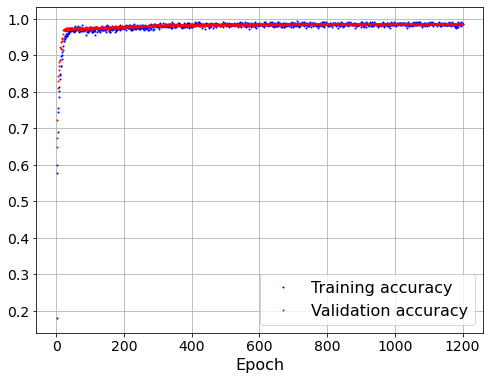

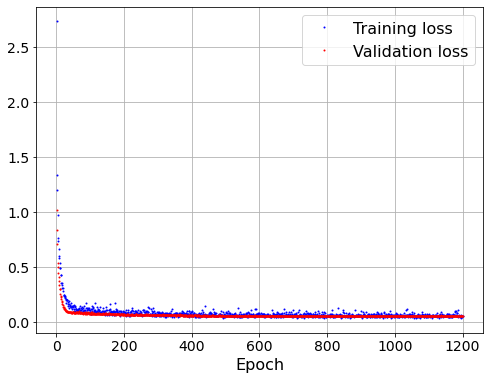

In [39]:
# Here we print the loss and accuracy
epochs = range(1, len(train_acc) + 1)
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc, "b.", markersize=2, label="Training accuracy")
plt.plot(epochs, val_acc, "r.", markersize=2, label="Validation accuracy")
# plt.title("Training and validation accuracy",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, "b.", markersize=2, label="Training loss")
plt.plot(epochs, val_loss, "r.", markersize=2, label="Validation loss")
# plt.title("Training and validation loss",fontsize=16)
plt.xlabel('Epoch',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid()
plt.legend(fontsize=16)
plt.show()

### Accuracy with the validation set

In [40]:
print(f"Validation acc: {transformer.evaluate(val_dataset)[1]:.3f}")

1/1 [==============================] - 6s 6s/step - loss: 0.0506 - accuracy: 0.9847
Validation acc: 0.985


### Saving the model

#### Saving only the weights

In [41]:
transformer.save_weights('Transformer_v8.0_weights.h5', overwrite=True, save_format='h5', options=None)

#### Saving the entire model

In [42]:
# H5 FORMAT
transformer.save('Transformer_v8.0_model.h5',
        overwrite=True,include_optimizer=False,save_format='h5',signatures=None,options=None)
# tf FORMAT (do not use, Keras still has problems with it)
# transformer.save('Transformer_v8.0_model.tf',
#         overwrite=True,include_optimizer=False,save_format='tf',signatures=None,options=None)

#### Loading the saved model

#### Entire model (use only h5 serialization, and then recompile!)

In [43]:
# transformer = keras.models.load_model(
#     "Transformer_v8.0_model.h5",
#     custom_objects={"TransformerEncoder": TransformerEncoder,
#                     "TransformerDecoder": TransformerDecoder,
#                     "PosEmbedding": PosEmbedding}) 

# transformer.compile(optimizer="adam", 
#                     loss="sparse_categorical_crossentropy", 
#                     metrics=["accuracy"])
# transformer.summary()

#### Only the weights (best loading method after recompiling the model)

In [44]:
# transformer.load_weights('Transformer_v8.0_weights.h5')

#### Check that prediction accuracy with the validation set has not changed using the saved model

In [45]:
# print(f"Validation acc: {transformer.evaluate(val_dataset)[1]:.3f}")

#### Preparing a generic basin frame for prediction

In [46]:
# # The following shows how the input is being modified during prediction by adding
# # a new frame with only a 'start of sequence' = 4, and the rest as padding
# input_frames = np.expand_dims(inputs_trj_basins_padded_1[-1:],axis=0)
# print(input_frames.shape,type(input_frames),input_frames.dtype)

# input1 = input_frames[0][0][:-3]
# input1 = ' '.join(map(str,input1))
# print(f'Input {input_frames.shape}:\n\n{input1}\n\n')

# decoded_sentence = (np.ones((215,))*6).astype('int32')
# decoded_sentence[0] = 4
# decoded_sentence = np.expand_dims(decoded_sentence,axis=(0,1))
# print(decoded_sentence.shape)
# input_sentence = np.concatenate((input_frames,decoded_sentence),axis=1)

# print(input_sentence.shape,type(input_sentence),input_sentence.dtype)

# input1_2 = input_sentence[0][0][:]
# input2_2 = input_sentence[0][1][:]

# input1_2 = ' '.join(map(str,input1_2))
# input2_2 = ' '.join(map(str,input2_2))
# print(f'Input {input_sentence.shape}:\n\n{input1_2}\n\n{input2_2}\n\n')

In [47]:
# Function to recursively predict the next position in the frame sequence from
# the previous ones already calculated

def predict_frame(input_sequence,model,mdsl,pad,startpad,endpad):
    decoded_sequence = (np.ones((mdsl,))*pad).astype('int32')
    decoded_sequence[0] = startpad
    decoded_sequence = np.expand_dims(decoded_sequence,axis=0)    
    end = np.array([endpad]).astype('int32')
    for i in range(mdsl):
        input_sequence_2 = [input_sequence,decoded_sequence] 
        prediction = model(input_sequence_2)
        sampled_token = np.argmax(prediction[0, i, :])
        if i+1 > mdsl:
            break
        decoded_sequence[:,i+1] = sampled_token
        if sampled_token == end:
            break            
     
    return decoded_sequence

### Hand calculation of predictions with the validation set

In [48]:
# # Validation set predictions

# n_frames = len(val_inputs1)
# predicted_frames_list = []
# diff_pred_target_pos_list = []
# diff_pred_target_list = []
# diff_pred_target_cum = 0.
# diff_pred_input = 0.

# start_frame = 0
# end_frame = n_frames
# n_cycle = 0

# mdsl = 215 # max_decoded_sequence_length
# pad = 6
# startpad = 4
# endpad = 5

# for cycle,cycle_input in enumerate(zip(val_inputs1[start_frame:end_frame],val_targets[start_frame:end_frame])):
#     n_cycle += 1
    
#     # Input frame
#     input_frame = cycle_input[0]
    
#     # We remove all paddings from the target
#     target = cycle_input[1][:-3] 

#     # We expand the dimensions so that the input frame appears to the network as a batch
#     predicted_frame = predict_frame(np.expand_dims(input_frame,axis=0),transformer,mdsl,pad,startpad,endpad)
#     predicted_frame = np.squeeze(predicted_frame)
    
#     # We remove all paddings from the prediction
#     predicted_frame = predicted_frame[1:-2].astype('int32')
#     predicted_frames_list.append([predicted_frame])
    
#     # Difference between the previous and current prediction
#     if cycle == 0:
#         previous_predicted_frame = np.copy(predicted_frame)
#     diff_previous_current_pred_ind = previous_predicted_frame!=predicted_frame
#     diff_previous_current_pred = sum(diff_previous_current_pred_ind)    
#     print(f'Frame {cycle}')
#     print(f'Current prediction vs previous      (number of positions): {diff_previous_current_pred}')

#     # Difference between the current prediction and the target    
#     diff_pred_target_ind = target!=predicted_frame    
#     diff_pred_target_pos = np.where(diff_pred_target_ind[0])[0]
#     diff_pred_target_pos_list.append([diff_pred_target_pos])
#     diff_pred_target = sum(diff_pred_target_ind)
#     diff_pred_target_list.append(diff_pred_target)
#     diff_pred_target_cum += diff_pred_target
    
#     # print(f'Frame {cycle}')
#     print(f'Current prediction vs target        (number of positions): {diff_pred_target}')
#     # print(f'Cumulative predictions vs targets (fraction of positions): {diff_pred_target_cum:.4f}')

# print(f'\nNumber of frames in the validation set:     {n_cycle}')
# print(f'Number of sequence positions in each frame: {sequence_length}')
# print(f'Transformer Validation Accuracy:            {1.0-(diff_pred_target_cum/(sequence_length*n_cycle)):.4f}')    

### Trajectory extension

Rapid convergence on a sequence that remains unchanged in the following extension cycles is avoided by introducing entropy in the prediction. In this case, instead of taking the peak of the probability distribution for the next predicted basin symbol, we accept a lower than maximum value. The higher the temperature we select in the 'sample_next' function, the higher the entropy of the prediction, so that lower than maximum values of the probability distribution of the 4 symbols are taken. 

In [49]:
def sample_next(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return probas

def predict_frame_with_entropy(input_sequence,
                               model,mdsl,
                               pad,startpad,
                               endpad,
                               temperature):
    
    # global variables declared for debugging purpose
    # global decoded_sequence, sampled_token
    
    decoded_sequence = (np.ones((mdsl,))*pad).astype('int32')
    decoded_sequence[0] = startpad
    decoded_sequence = np.expand_dims(decoded_sequence,axis=0)    
    end = np.array([endpad]).astype('int32')
    for i in range(mdsl):
        input_sequence_2 = [input_sequence,decoded_sequence] 
        prediction = model(input_sequence_2)
        next_token = sample_next(prediction[0, i, :],temperature)
        sampled_token = np.argmax(next_token)
        # if i+1 > mdsl:
        if i+1 == mdsl:
            break        
        decoded_sequence[:,i+1] = sampled_token
        if sampled_token == end:
            break            

    return decoded_sequence    

#### Trajectory extension from an initial  frame of basins: example 1

We choose a frame from the validation trajectory of basins. 

In [50]:
# Choose a frame from the validation trajectory of basins. This vector of basins 
# is used to extend the trajectory of basins. 

input_basin_frame_number = 96

input_frame = np.concatenate((val_basins[input_basin_frame_number],[6,6,6]),axis=0)
print(input_frame.shape)
print(*input_frame)
print(*input_frame[:-3])

(215,)
0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6
0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [51]:
# Here we extend the trajectory from the input frame. 
extended_trj_basins_transformer = []
n_extensions = 100 
temperature = 1.5 # default = 1.5

mdsl = 215 # max_decoded_sequence_length
pad = 6
startpad = 4
endpad = 5

# We need to expand the dimensions so that the input appears to the network as a batch
# input_frame = val_inputs1[input_frame_number]
input_frame = np.expand_dims(input_frame,axis=0)

cycle = 1
frame_number = 1
while cycle <= n_extensions:
   
    # Predict next frame and strip all padding
    next_frame = predict_frame_with_entropy(input_frame,
                                            transformer,
                                            mdsl,
                                            pad,
                                            startpad,
                                            endpad,
                                            temperature)
    next_frame = np.squeeze(next_frame)
    next_frame = next_frame[1:-2].astype('int32')
    
    extended_trj_basins_transformer.append(next_frame)

    # Strip new_input padding 
    input_frame = np.squeeze(input_frame)
    input_frame = input_frame[:-3]    
    
    print(f'Input frame {frame_number} {input_frame.shape}:')
    print(*input_frame)
    print(f'Predicted frame {next_frame.shape}:')
    print(*next_frame)    

    # Identify different positions between input and predicted frame
    diff_ind = input_frame!=next_frame    
    diff_ind_pos = np.where(diff_ind)[0]    
    next_frame_marked = np.copy(next_frame) 
    next_frame_marked[diff_ind] = 8
    
    print(f'Predicted frame marked for differences at positions: ', [*diff_ind_pos])
    print(*next_frame_marked,'\n')    

    # The predicted frame becomes the new input
    next_frame = np.concatenate((next_frame,[6,6,6]),axis=0)
    next_frame = np.expand_dims(next_frame,axis=0)
    input_frame = next_frame

    # Check for frames having low probability basin or termination symbols (s>3). 
    # If this occurs, update only the frame number    
    if np.max(next_frame[0][:-3]) > 3:        
        print(f'Extension error at frame {frame_number}')
        frame_number += 1
    else:
        frame_number += 1
        cycle += 1
       

Input frame 1 (212,):
0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 2 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 39, 40, 43, 44, 53, 54, 78, 99, 158, 200]
0 0 0 

Input frame 7 (212,):
0 0 0 0 0 3 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 1 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 11, 99, 128, 132]
0 0 0 0 0 3 0 1 8 1 1 8 1 1 1 

Input frame 13 (212,):
0 0 0 0 0 3 0 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [10, 11, 99, 122, 152, 174]
0 0 0 0 0 3 0 1 1 1 8 8

Input frame 19 (212,):
0 0 0 0 0 3 0 1 1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 2 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 3 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1 2 0 1 1 0 2 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [30, 44, 45, 47, 54, 78, 99, 128, 151, 157]
0 0 0 0

Input frame 25 (212,):
0 0 0 0 0 3 0 1 1 0 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 2 0 1 0 2 1 1 1 1 1 1 1 1 0 2 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 3 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 0 2 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 2 0 2 3 1 1 1 1 1 1 1 1 1 1 1 3 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 3 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 23, 38, 53, 55, 112, 113, 128, 143, 157]
0 0 0 

Input frame 31 (212,):
0 0 0 0 0 3 0 0 0 1 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 0 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 10, 30, 38, 39, 55]
0 0 0 0 0 3 0 0 8 1 8 0 2 1

Input frame 37 (212,):
0 0 0 0 0 3 0 0 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [7, 8, 11, 54, 99, 128]
0 0 0 0 0 3 0 8 8 1 2 8 1 1

Input frame 43 (212,):
0 0 0 0 0 3 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 54, 58, 78, 157]
0 0 0 0 0 3 0 1 8 1 2 1 1 1 1 

Input frame 49 (212,):
0 0 0 0 0 3 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 2 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [10, 51, 58, 78, 152]
0 0 0 0 0 3 0 0 2 1 8 1 1 1 1

Input frame 55 (212,):
0 0 0 0 0 3 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 0 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 3 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1
Predicted frame marked for differences at positions:  [7, 8, 11, 78, 83, 167, 200, 206, 207, 208]
0 0 0 0

Input frame 61 (212,):
0 0 0 0 0 3 0 3 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 2 1 1 1 1 1 1 1 1 1 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 1 3 0 0 2 0 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 5 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
Predicted frame marked for differences at positions:  [4, 7, 8, 11, 39, 40, 44, 58, 187, 188, 189, 190, 1

Input frame 67 (212,):
0 0 0 0 0 3 0 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 3 0 1 1 1 2 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [10, 12, 54, 55, 56, 78, 143, 152, 158]
0 0 0 0 0 3

Input frame 73 (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 1 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 3 1 1 1 1 1 1 1 1 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 11, 30, 39, 43, 44, 54, 57, 136]
0 0 0 0 0 3 0 

Input frame 79 (212,):
0 0 0 0 0 3 0 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 9, 30, 128, 149]
0 0 0 0 0 3 0 1 8 8 2 1 1 1 1 

Input frame 85 (212,):
0 0 0 0 0 3 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 3 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [43, 44, 50, 57, 78, 109, 128]
0 0 0 0 0 3 0 1 1 1 

Input frame 91 (212,):
0 0 0 0 0 3 0 0 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 1 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [7, 8, 10, 11, 38, 39, 40, 55, 58, 99, 128, 132, 15

Input frame 97 (212,):
0 0 0 0 0 3 0 1 1 1 2 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 3 1 1 1 1 1 1 2 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 3 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 1 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 2 1 3 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 10, 11, 12, 47, 55, 71, 99, 127, 128, 199]
0 0 

In [52]:
# Extended frames. This selection only contains the frames without not 
# allowed symbols (symbols > 3)
valid_i = 1
for i in range(len(extended_trj_basins_transformer)):
    if np.max(extended_trj_basins_transformer[i]) > 3:
        continue

    print(f'Predicted Frame {valid_i} :')
    print(*extended_trj_basins_transformer[i])
    valid_i += 1

Predicted Frame 1 :
0 0 0 0 0 3 0 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 2 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 2 :
0 0 0 0 0 3 0 0 2 1 2 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 3 :
0 0 0 0 0 3 0 0 2 0 2 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 0 1 0 1 0 2 1 

0 0 0 0 0 3 0 0 2 1 3 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 0 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 22 :
0 0 0 0 0 3 0 0 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 23 :
0 0 0 0 0 3 0 1 1 0 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 2 0 1 0 2 1 1 1 1 1 1 1 1 0 2 

0 0 0 0 0 3 0 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 43 :
0 0 0 0 0 3 0 1 2 0 3 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 44 :
0 0 0 0 0 3 0 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 

0 0 0 0 0 3 0 0 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 62 :
0 0 0 0 0 3 0 0 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 2 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 1 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 63 :
0 0 0 0 0 3 0 0 2 1 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 

0 0 0 0 0 3 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 83 :
0 0 0 0 0 3 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 3 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 84 :
0 0 0 0 0 3 0 0 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 2 1 

In [53]:
# Convert basin trajectory into angle trajectory using centroids
extended_trj_phipsi_from_basins = []
for i,frame in enumerate(extended_trj_basins_transformer):
    frame = np.squeeze(frame)
    if np.max(frame)>3:
        continue
    single_frame_phi_psi = []
    for j,basin in enumerate(frame):
        if basin>3:
            print(i,j,basin)
            print(*frame)
            break
        
        phi_psi = val_centroids[basin]
        single_frame_phi_psi.append(phi_psi.tolist())
        single_frame_phi_psi_ndarray = np.array(single_frame_phi_psi)
    extended_trj_phipsi_from_basins.append(single_frame_phi_psi_ndarray)

extended_trj_phipsi_from_basins = np.array(extended_trj_phipsi_from_basins)

print(extended_trj_phipsi_from_basins.shape)
print(extended_trj_phipsi_from_basins[0])

# Convert degrees to radians
deg_to_rad = np.pi/180.
extended_trj_phipsi = extended_trj_phipsi_from_basins * deg_to_rad

# Here we check the reshaping was correct
print(extended_trj_phipsi.shape)
print(extended_trj_phipsi[0])

(100, 212, 2)
[[-102.05759904  138.45288152]
 [-102.05759904  138.45288152]
 [-102.05759904  138.45288152]
 ...
 [ -72.86845223  -35.46093418]
 [ -72.86845223  -35.46093418]
 [ -72.86845223  -35.46093418]]
(100, 212, 2)
[[-1.78124113  2.41645864]
 [-1.78124113  2.41645864]
 [-1.78124113  2.41645864]
 ...
 [-1.27179441 -0.61891006]
 [-1.27179441 -0.61891006]
 [-1.27179441 -0.61891006]]


#### Conversion of the extended trajectory frame to Modeller format
This conversion requires substituting with MDAnalysis all the CD atoms of ILE to CD1 and the O1,O2 atoms of the last residue to O and OXT.

#### Check that Modeller correctly implements dihedral restraints

In [54]:
# Convert the basins of the the validation frame selected to start 
# extension into phi-psi angles in radians 

u_val_0_basins = val_basins[input_basin_frame_number]
print(*u_val_0_basins)

u_val_0_phipsi_radians = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians.append(phi_psi.tolist())
u_val_0_phipsi_radians = np.array(u_val_0_phipsi_radians)

0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [55]:
print(val_centroids)

[[-102.05759904  138.45288152]
 [ -72.86845223  -35.46093418]
 [  97.28764961    2.54432813]
 [ 112.40232232  177.0253939 ]]


In [56]:
print(*u_val_0_phipsi_radians[:10])

[-1.78124113  2.41645864] [-1.78124113  2.41645864] [-1.78124113  2.41645864] [-1.78124113  2.41645864] [-1.78124113  2.41645864] [1.96179061 3.08967598] [-1.78124113  2.41645864] [-1.27179441 -0.61891006] [1.69798981 0.0444069 ] [-1.27179441 -0.61891006]


In [57]:
# using MDAnalysis write out without hydrogens the input frame 
# from the 'protein' validation trajectory 

# This frame does not have to be the same frame selected to start the basin
# extension. 

# The protein conformation in this frame will be the starting point,
# u_val.pdb, to apply the consecutive phi-psi angle changes.

# For example, we expanded the 'basin' trj using validation basin
# frame number 96, but we select validation protein frame number 48 
# as the starting point to generate a 'protein' extended trj

input_protein_frame_number = 48

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('protein and not (name H* )')

with mda.Writer("u_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('u_val.pdb','u_val.pdb')

u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'A'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("u_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [58]:
# After converting HSD to HIS, write out again the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')


Protein sequence in 1 letter code:
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


#### Modeller environment

In [59]:
# Initial alignment

sequence = prot_sequence_slc + '*'

with open("alignment.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:u_val_0.pdb:1:A:{n_res}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)
    

In [60]:
# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'u_val_0'
mdl = complete_pdb(env, code + '.pdb')
# mdl.write(file = code + '.ini')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,214): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

    # Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                           features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                     features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                           weights=[100,100],
                           means=[u_val_0_phipsi_radians[i-2,:].tolist(),                                
                                  u_val_0_phipsi_radians[i-2,:].tolist()],                                
                           stdevs=[[0.1,0.1],[0.1,0.1]],
                           correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
        # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
            alnfile  = 'alignment.ali',     # alignment filename
            knowns   = 'orig',              # codes of the templates
            sequence = 'seq',
            )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='u_val_0_min.pdb')


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             3561.83887



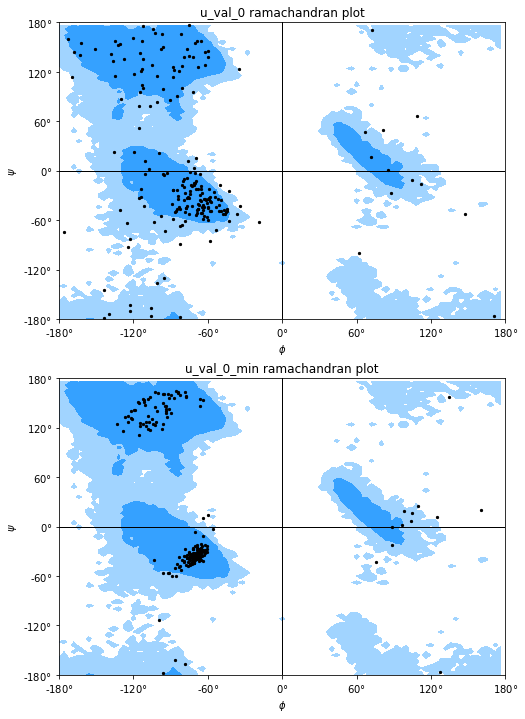

In [61]:
# Here we check that the phi=psi constraints really worked. After minimization 
# the ramachandran plot should show phi-psi angles clustered around the centroids
# To select a range of frames in a trajectory 
# use .run(startframe,endframe+1)

# Ramachandran angles in the reference protein. 
u_val_0 = mda.Universe('u_val_0.pdb','u_val_0.pdb')
u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')
u_val_0_rama = dihedrals.Ramachandran(u_val_0_protein).run()
plt.figure(figsize=(8, 12)) 
plt.subplot(2,1,1)
u_val_0_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0 ramachandran plot') 
u_val_0_phipsi_obs_radians = u_val_0_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_phipsi.shape}')
# print(u_val_0_phipsi_radians.shape)
# print(u_val_0_phipsi_radians[0][:6])

# Ramachandran angles in the minimized reference protein. 
u_val_0_min = mda.Universe('u_val_0_min.pdb','u_val_0_min.pdb')
u_val_0_min_protein = u_val_0_min.select_atoms('protein and not (name H* )')
u_val_0_min_rama = dihedrals.Ramachandran(u_val_0_min_protein).run()
plt.subplot(2,1,2)
u_val_0_min_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0_min ramachandran plot')          
u_val_0_min_phipsi_radians = u_val_0_min_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_min_phipsi.shape}')
# print(u_val_0_min_phipsi_radians.shape)
# print(u_val_0_min_phipsi_radians[0][:6])

#### Comparison of initial and phi-psi constrained minimized structures

In [62]:
# Backbone rmsd between the structures
RMSD = rms.rmsd(u_val_0_min.select_atoms('backbone and not(name H*)').positions,  # coordinates to align
         u_val_0.select_atoms('backbone and not(name H*)').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates
print(f'RMSD[backbone] (u_val_0_min vs. u_val_0): {RMSD:.3f}')

# Superposition before and after minimization
rmsds = align.alignto(u_val_0_min,  # minimized
                      u_val_0,  # reference
                      select='name CA', # selection to operate on
                      match_atoms=True) # whether to match atoms
print(rmsds)
nv.show_mdanalysis(mda.Merge(u_val_0_min.atoms, u_val_0.atoms))

RMSD[backbone] (u_val_0_min vs. u_val_0): 1.300
(1.321768434598319, 1.2968598367980957)


NGLWidget()

#### View the extended trajectory 

In [63]:
# Select frames to view from the extension array 
extended_list = []
ext_frame_numbers = np.arange(0,n_extensions,10)
sequence = prot_sequence_slc + '*'

for ext_frame_number_ind,ext_frame_number in enumerate(ext_frame_numbers):
    
    # Modeller environment
    log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
    env = Environ()
    env.io.atom_files_directory = '.'
    env.edat.dynamic_sphere = True

    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')

    if ext_frame_number == 0:
        # here we choose the minimized structure selected for extension
        code = 'u_val_0_min'                
    else:
        # here we choose the previous extended frame as the start frame 
        code = 'u_val_extension_' + str(ext_frame_numbers[ext_frame_number_ind-1])
        
    ali_code = code + '.pdb'
    with open("alignment_min.ali", "w") as text_file:
        print(f'>P1;orig\nstructureX:{ali_code}:1:A:{n_res}:A::::\n{sequence}',file=text_file)
        print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)        
        
    mdl = complete_pdb(env, code + '.pdb')       
    
    rsr = mdl.restraints

    # Select all atoms:
    atmsel = Selection(mdl)    

    # Generate static restraints:
    rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

    # Example of phi and phi angles atoms definition
    # 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
    # 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

    # Add dynamic restraints on the phi-psi dihedrals
    for i in range(2,214): 
        phi_1 = mdl.atoms['C:'+str(i-1)+':A']
        phi_2 = mdl.atoms['N:'+str(i)+':A']
        phi_3 = mdl.atoms['CA:'+str(i)+':A']
        phi_4 = mdl.atoms['C:'+str(i)+':A']    
        psi_1 = mdl.atoms['N:'+str(i)+':A']
        psi_2 = mdl.atoms['CA:'+str(i)+':A']
        psi_3 = mdl.atoms['C:'+str(i)+':A']
        psi_4 = mdl.atoms['N:'+str(i+1)+':A']
        
        # Binormal constraints
        rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                               features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                         features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                               weights=[100,100],
                               means=[extended_trj_phipsi[ext_frame_number][i-2,:].tolist(),
                                      extended_trj_phipsi[ext_frame_number][i-2,:].tolist()],
                               stdevs=[[0.1,0.1],[0.1,0.1]],
                               correls=[0.5,0.5]))    
 
    mdl.restraints.write(file = code + '.rsr')

    # Addition of restraints to the default ones
    class RestrainModel(AutoModel):
        def special_restraints(self, aln):
            rsr = self.restraints
            # Add restraints from file:
            rsr.append(file = code + '.rsr')          

    a = RestrainModel(env,
                alnfile  = 'alignment_min.ali',     # alignment filename
                knowns   = 'orig',              # codes of the templates
                sequence = 'seq',
                )              # code of the target
    a.starting_model= 1                 # index of the first model
    a.ending_model  = 1                 # index of the last model
                                        # (determines how many models to calculate)
    a.make()                            # do comparative modeling
    
    a.write(file='u_val_extension_' + str(ext_frame_number) + '.pdb')   

    extended_list.append('u_val_extension_' + str(ext_frame_number) + '.pdb')    


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2711.57275

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2468.22974

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename   

In [64]:
# Check extended list
extended_list = extended_list[:len(ext_frame_numbers)]
print(extended_list)

['u_val_extension_0.pdb', 'u_val_extension_10.pdb', 'u_val_extension_20.pdb', 'u_val_extension_30.pdb', 'u_val_extension_40.pdb', 'u_val_extension_50.pdb', 'u_val_extension_60.pdb', 'u_val_extension_70.pdb', 'u_val_extension_80.pdb', 'u_val_extension_90.pdb']


In [65]:
# If reverse is True the displayed trj will goes back and forth
reverse = True

if reverse:
    extended_list.append(extended_list[::-1])

# ife tag as input_frame_early    
u_val_ext_trj_ex1 = mda.Universe('u_val_0_min.pdb',extended_list)

# Fit in place extended trj to the reference structure
alignment_ex1 = align.AlignTraj(u_val_ext_trj_ex1, u_val_0_min, in_memory=True)
alignment_ex1.run()

view_u_val_ext_trj_ex1 = nv.show_mdanalysis(u_val_ext_trj_ex1)

view_u_val_ext_trj_ex1.center()
view_u_val_ext_trj_ex1


NGLWidget(max_frame=19)

#### Trajectory extension from an initial  frame of basins: example 2

We choose a frame from the validation trajectory of basins. 

In [66]:
# Choose a frame from the validation trajectory of basins. This vector of basins 
# is used to extend the trajectory of basins. 

input_basin_frame_number = 48

input_frame = np.concatenate((val_basins[input_basin_frame_number],[6,6,6]),axis=0)
print(input_frame.shape)
print(*input_frame)
print(*input_frame[:-3])

(215,)
0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 6 6 6
0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [67]:
# Here we extend the trajectory from the input frame. 
extended_trj_basins_transformer = []
n_extensions = 100 
temperature = 1.5 # default = 1.5

mdsl = 215 # max_decoded_sequence_length
pad = 6
startpad = 4
endpad = 5

# We need to expand the dimensions so that the input appears to the network as a batch
# input_frame = val_inputs1[input_frame_number]
input_frame = np.expand_dims(input_frame,axis=0)

cycle = 1
frame_number = 1
while cycle <= n_extensions:
   
    # Predict next frame and strip all padding
    next_frame = predict_frame_with_entropy(input_frame,
                                            transformer,
                                            mdsl,
                                            pad,
                                            startpad,
                                            endpad,
                                            temperature)
    next_frame = np.squeeze(next_frame)
    next_frame = next_frame[1:-2].astype('int32')
    
    extended_trj_basins_transformer.append(next_frame)

    # Strip new_input padding 
    input_frame = np.squeeze(input_frame)
    input_frame = input_frame[:-3]    
    
    print(f'Input frame {frame_number} {input_frame.shape}:')
    print(*input_frame)
    print(f'Predicted frame {next_frame.shape}:')
    print(*next_frame)    

    # Identify different positions between input and predicted frame
    diff_ind = input_frame!=next_frame    
    diff_ind_pos = np.where(diff_ind)[0]    
    next_frame_marked = np.copy(next_frame) 
    next_frame_marked[diff_ind] = 8
    
    print(f'Predicted frame marked for differences at positions: ', [*diff_ind_pos])
    print(*next_frame_marked,'\n')    

    # The predicted frame becomes the new input
    next_frame = np.concatenate((next_frame,[6,6,6]),axis=0)
    next_frame = np.expand_dims(next_frame,axis=0)
    input_frame = next_frame

    # Check for frames having low probability basin or termination symbols (s>3). 
    # If this occurs, update only the frame number    
    if np.max(next_frame[0][:-3]) > 3:        
        print(f'Extension error at frame {frame_number}')
        frame_number += 1
    else:
        frame_number += 1
        cycle += 1
       

Input frame 1 (212,):
0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [11, 12, 29, 47, 54, 78]
0 0 0 0 0 3 0 1 1 1 0 8 8 1

Input frame 7 (212,):
0 0 0 0 0 3 0 1 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 1 0 0 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 2 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [10, 30, 54, 55, 58, 71, 108, 127, 152, 153, 159, 19

Input frame 13 (212,):
0 0 0 0 1 3 0 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 3 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 1 3 0 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [40, 78, 157]
0 0 0 0 1 3 0 1 1 1 0 0 2 1 1 1 1 1 1

Input frame 19 (212,):
0 0 0 0 0 3 0 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 2 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 1 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [9, 11, 12, 43, 44, 45, 99, 141, 142, 157]
0 0 0 0 

Input frame 25 (212,):
0 0 0 0 0 3 0 0 2 1 3 0 2 1 0 2 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 2 1 1 1 1 1 1 1 0 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 2 1 1 1 1 1 1 1 1 1 0 3 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [7, 8, 10, 11, 12, 14, 15, 44, 45, 53, 54, 55, 107,

Input frame 31 (212,):
0 0 0 0 0 3 0 1 2 1 2 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 2 2 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 3 1 0 2 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 2 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 9, 11, 38, 41, 44, 54, 71, 78, 128, 151, 155, 1

Input frame 37 (212,):
0 0 0 0 0 3 0 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 0 2 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 2 1 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 30, 50, 51, 188]
0 0 0 0 0 3 0 1 8 1 1 3 1 1 1 

Input frame 43 (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 0 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [10, 11, 12, 48, 200]
0 0 0 0 0 3 0 1 1 1 8 8 8 1 1

Input frame 49 (212,):
0 0 0 0 0 3 0 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 1 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [11, 28, 53, 78, 136, 151, 157, 199]
0 0 0 0 0 3 0 

Input frame 55 (212,):
0 0 0 0 0 3 0 1 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [43, 44, 108, 120, 158]
0 0 0 0 0 3 0 1 1 0 2 2 1 1

Input frame 61 (212,):
0 0 0 0 0 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 1 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 3 2 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 1 0 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [10, 11, 39, 40, 66, 67, 99, 128, 151, 157]
0 0 0 0

Input frame 67 (212,):
0 0 0 0 0 3 0 1 1 1 3 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 3 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 2 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 2 1 3 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 3 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 78, 99, 157]
0 0 0 0 0 3 0 1 8 1 3 3 2 1 1 1 1 

Input frame 73 (212,):
0 0 0 0 0 3 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 3 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [12, 40, 121, 151, 157]
0 0 0 0 0 3 0 1 1 0 0 0 8 1

Input frame 79 (212,):
0 0 0 0 0 3 0 1 2 1 1 0 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1 1 1 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 0 2 1 2 0 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 2 1 1 0 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [7, 10, 30, 47, 153]
0 0 0 0 0 3 0 8 2 1 8 0 1 1 1 

Input frame 85 (212,):
0 0 0 0 0 3 0 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 1 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 40, 78, 128, 136, 152]
0 0 0 0 0 3 0 1 8 1 1 2 

Input frame 91 (212,):
0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 1 0 0 1 0 0 2 0 0 1 1 1 3 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 1 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 1 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 3 1 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [9, 11, 27, 99, 148, 199]
0 0 0 0 0 3 0 1 1 8 1 8 1

Input frame 97 (212,):
0 0 0 0 0 3 0 1 2 0 3 1 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 1 0 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame (212,):
0 0 0 0 0 3 0 1 1 0 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 1 1 3 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 3 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted frame marked for differences at positions:  [8, 10, 11, 25, 56, 83, 99, 157]
0 0 0 0 0 3 0 1 8 

In [68]:
# Extended frames. This selection only contains the frames without not 
# allowed symbols (symbols > 3)
valid_i = 1
for i in range(len(extended_trj_basins_transformer)):
    if np.max(extended_trj_basins_transformer[i]) > 3:
        continue

    print(f'Predicted Frame {valid_i} :')
    print(*extended_trj_basins_transformer[i])
    valid_i += 1

Predicted Frame 1 :
0 0 0 0 0 3 0 1 1 1 0 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 2 :
0 0 0 1 0 3 0 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 3 0 1 0 2 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 3 :
0 0 0 0 0 3 0 1 2 1 1 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 

0 0 0 0 0 3 0 1 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 23 :
0 0 0 0 0 3 0 1 1 1 3 0 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 24 :
0 0 0 0 0 3 0 0 2 1 3 0 2 1 0 2 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 2 1 1 1 1 1 1 1 0 1 

0 0 0 0 0 3 0 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 44 :
0 0 0 0 0 3 0 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 1 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 45 :
0 0 0 0 0 3 0 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 2 

0 0 0 0 0 3 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 0 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 1 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 2 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 65 :
0 0 0 0 0 3 0 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 3 0 0 0 0 1 1 1 1 1 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 2 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 66 :
0 0 0 0 0 3 0 1 1 1 3 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 3 

0 0 0 0 0 3 0 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 86 :
0 0 0 0 0 3 0 1 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 3 0 0 0 0 3 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 0 0 1 1 1 2 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Predicted Frame 87 :
0 0 0 0 0 3 0 1 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 1 1 1 1 1 2 0 2 0 1 0 2 1 1 1 1 1 1 1 1 1 2 

In [69]:
# Convert basin trajectory into angle trajectory using centroids
extended_trj_phipsi_from_basins = []
for i,frame in enumerate(extended_trj_basins_transformer):
    frame = np.squeeze(frame)
    if np.max(frame)>3:
        continue
    single_frame_phi_psi = []
    for j,basin in enumerate(frame):
        if basin>3:
            print(i,j,basin)
            print(*frame)
            break
        
        phi_psi = val_centroids[basin]
        single_frame_phi_psi.append(phi_psi.tolist())
        single_frame_phi_psi_ndarray = np.array(single_frame_phi_psi)
    extended_trj_phipsi_from_basins.append(single_frame_phi_psi_ndarray)

extended_trj_phipsi_from_basins = np.array(extended_trj_phipsi_from_basins)

print(extended_trj_phipsi_from_basins.shape)
print(extended_trj_phipsi_from_basins[0])

# Convert degrees to radians
deg_to_rad = np.pi/180.
extended_trj_phipsi = extended_trj_phipsi_from_basins * deg_to_rad

# Here we check the reshaping was correct
print(extended_trj_phipsi.shape)
print(extended_trj_phipsi[0])

(100, 212, 2)
[[-102.05759904  138.45288152]
 [-102.05759904  138.45288152]
 [-102.05759904  138.45288152]
 ...
 [ -72.86845223  -35.46093418]
 [ -72.86845223  -35.46093418]
 [ -72.86845223  -35.46093418]]
(100, 212, 2)
[[-1.78124113  2.41645864]
 [-1.78124113  2.41645864]
 [-1.78124113  2.41645864]
 ...
 [-1.27179441 -0.61891006]
 [-1.27179441 -0.61891006]
 [-1.27179441 -0.61891006]]


#### Conversion of the extended trajectory frame to Modeller format
This conversion requires substituting with MDAnalysis all the CD atoms of ILE to CD1 and the O1,O2 atoms of the last residue to O and OXT.

#### Check that Modeller correctly implements dihedral restraints

In [70]:
# Convert the basins of the the validation frame selected to start 
# extension into phi-psi angles in radians 

u_val_0_basins = val_basins[input_basin_frame_number]
print(*u_val_0_basins)

u_val_0_phipsi_radians = []
for basin in u_val_0_basins:
    phi_psi = val_centroids[basin]*deg_to_rad
    u_val_0_phipsi_radians.append(phi_psi.tolist())
u_val_0_phipsi_radians = np.array(u_val_0_phipsi_radians)

0 0 0 0 0 3 0 1 1 1 0 3 2 1 1 1 1 1 1 1 1 1 1 2 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 2 0 1 0 2 1 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 2 0 0 1 0 1 1 1 1 1 1 1 1 1 1 2 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 2 0 0 0 0 1 1 1 0 0 0 1 0 0 2 1 0 1 1 1 2 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1


In [71]:
print(*u_val_0_phipsi_radians[:6])

[-1.78124113  2.41645864] [-1.78124113  2.41645864] [-1.78124113  2.41645864] [-1.78124113  2.41645864] [-1.78124113  2.41645864] [1.96179061 3.08967598]


In [72]:
# The protein conformation in this frame will be the starting point,
# u_val.pdb, to apply the consecutive phi-psi angle changes.

# For example, we expanded the 'basin' trj using validation basin
# frame number 48, but here we select validation protein frame number 96 
# as the starting point to generate a 'protein' extended trj

input_protein_frame_number = 96

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('protein and not (name H* )')

with mda.Writer("u_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('u_val.pdb','u_val.pdb')

u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'A'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("u_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [73]:
# After converting HSD to HIS, write out again the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')


Protein sequence in 1 letter code:
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


#### Modeller environment

In [74]:
# Initial alignment

sequence = prot_sequence_slc + '*'

with open("alignment.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:u_val_0.pdb:1:A:{n_res}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)
    

In [75]:
# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'u_val_0'
mdl = complete_pdb(env, code + '.pdb')
# mdl.write(file = code + '.ini')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,214): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

    # Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                           features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                     features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                           weights=[100,100],
                           means=[u_val_0_phipsi_radians[i-2,:].tolist(),                                
                                  u_val_0_phipsi_radians[i-2,:].tolist()],                                
                           stdevs=[[0.1,0.1],[0.1,0.1]],
                           correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
        # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
            alnfile  = 'alignment.ali',     # alignment filename
            knowns   = 'orig',              # codes of the templates
            sequence = 'seq',
            )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='u_val_0_min.pdb')


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             3119.61890



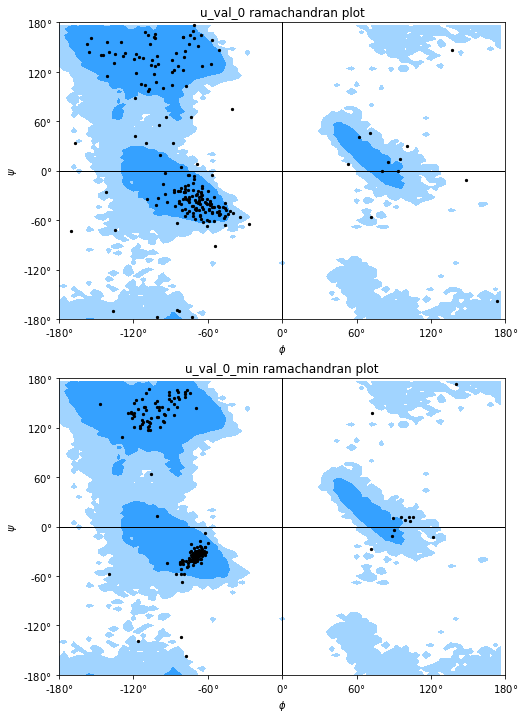

In [76]:
# Here we check that the phi=psi constraints really worked. After minimization 
# the ramachandran plot should show phi-psi angles clustered around the centroids
# To select a range of frames in a trajectory 
# use .run(startframe,endframe+1)

# Ramachandran angles in the reference protein. 
u_val_0 = mda.Universe('u_val_0.pdb','u_val_0.pdb')
u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')
u_val_0_rama = dihedrals.Ramachandran(u_val_0_protein).run()
plt.figure(figsize=(8, 12)) 
plt.subplot(2,1,1)
u_val_0_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0 ramachandran plot') 
u_val_0_phipsi_obs_radians = u_val_0_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_phipsi.shape}')
# print(u_val_0_phipsi_radians.shape)
# print(u_val_0_phipsi_radians[0][:6])

# Ramachandran angles in the minimized reference protein. 
u_val_0_min = mda.Universe('u_val_0_min.pdb','u_val_0_min.pdb')
u_val_0_min_protein = u_val_0_min.select_atoms('protein and not (name H* )')
u_val_0_min_rama = dihedrals.Ramachandran(u_val_0_min_protein).run()
plt.subplot(2,1,2)
u_val_0_min_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0_min ramachandran plot')          
u_val_0_min_phipsi_radians = u_val_0_min_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_min_phipsi.shape}')
# print(u_val_0_min_phipsi_radians.shape)
# print(u_val_0_min_phipsi_radians[0][:6])

#### Comparison of initial and phi-psi constrained minimized structures

In [77]:
# Backbone rmsd between the structures
RMSD = rms.rmsd(u_val_0_min.select_atoms('backbone and not(name H*)').positions,  # coordinates to align
         u_val_0.select_atoms('backbone and not(name H*)').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates
print(f'RMSD[backbone] (u_val_0_min vs. u_val_0): {RMSD:.3f}')

# Superposition before and after minimization
rmsds = align.alignto(u_val_0_min,  # minimized
                      u_val_0,  # reference
                      select='name CA', # selection to operate on
                      match_atoms=True) # whether to match atoms
print(rmsds)
nv.show_mdanalysis(mda.Merge(u_val_0_min.atoms, u_val_0.atoms))

RMSD[backbone] (u_val_0_min vs. u_val_0): 2.462
(2.688979542855211, 2.4460093253768598)


NGLWidget()

#### View the extended trajectory 

In [78]:
# Select frames to view from the extension array 
extended_list = []
ext_frame_numbers = np.arange(0,n_extensions,10)
sequence = prot_sequence_slc + '*'

for ext_frame_number_ind,ext_frame_number in enumerate(ext_frame_numbers):
    
    # Modeller environment
    log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
    env = Environ()
    env.io.atom_files_directory = '.'
    env.edat.dynamic_sphere = True

    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')

    if ext_frame_number == 0:
        # here we choose the minimized structure selected for extension
        code = 'u_val_0_min'                
    else:
        # here we choose the previous extended frame as the start frame 
        code = 'u_val_extension_' + str(ext_frame_numbers[ext_frame_number_ind-1])
        
    ali_code = code + '.pdb'
    with open("alignment_min.ali", "w") as text_file:
        print(f'>P1;orig\nstructureX:{ali_code}:1:A:{n_res}:A::::\n{sequence}',file=text_file)
        print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)        
        
    mdl = complete_pdb(env, code + '.pdb')       
    
    rsr = mdl.restraints

    # Select all atoms:
    atmsel = Selection(mdl)    

    # Generate static restraints:
    rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

    # Example of phi and phi angles atoms definition
    # 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
    # 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

    # Add dynamic restraints on the phi-psi dihedrals
    for i in range(2,214): 
        phi_1 = mdl.atoms['C:'+str(i-1)+':A']
        phi_2 = mdl.atoms['N:'+str(i)+':A']
        phi_3 = mdl.atoms['CA:'+str(i)+':A']
        phi_4 = mdl.atoms['C:'+str(i)+':A']    
        psi_1 = mdl.atoms['N:'+str(i)+':A']
        psi_2 = mdl.atoms['CA:'+str(i)+':A']
        psi_3 = mdl.atoms['C:'+str(i)+':A']
        psi_4 = mdl.atoms['N:'+str(i+1)+':A']
        
        # Binormal constraints
        rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                               features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                         features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                               weights=[100,100],
                               means=[extended_trj_phipsi[ext_frame_number][i-2,:].tolist(),
                                      extended_trj_phipsi[ext_frame_number][i-2,:].tolist()],
                               stdevs=[[0.1,0.1],[0.1,0.1]],
                               correls=[0.5,0.5]))    
 
    mdl.restraints.write(file = code + '.rsr')

    # Addition of restraints to the default ones
    class RestrainModel(AutoModel):
        def special_restraints(self, aln):
            rsr = self.restraints
            # Add restraints from file:
            rsr.append(file = code + '.rsr')          

    a = RestrainModel(env,
                alnfile  = 'alignment_min.ali',     # alignment filename
                knowns   = 'orig',              # codes of the templates
                sequence = 'seq',
                )              # code of the target
    a.starting_model= 1                 # index of the first model
    a.ending_model  = 1                 # index of the last model
                                        # (determines how many models to calculate)
    a.make()                            # do comparative modeling
    
    a.write(file='u_val_extension_' + str(ext_frame_number) + '.pdb')   

    extended_list.append('u_val_extension_' + str(ext_frame_number) + '.pdb')    


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2095.68872

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             3210.36084

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename   

In [79]:
# Check extended list
extended_list = extended_list[:len(ext_frame_numbers)]
print(extended_list)

['u_val_extension_0.pdb', 'u_val_extension_10.pdb', 'u_val_extension_20.pdb', 'u_val_extension_30.pdb', 'u_val_extension_40.pdb', 'u_val_extension_50.pdb', 'u_val_extension_60.pdb', 'u_val_extension_70.pdb', 'u_val_extension_80.pdb', 'u_val_extension_90.pdb']


In [80]:
# If reverse is True the displayed trj will goes back and forth
reverse = True

if reverse:
    extended_list.append(extended_list[::-1])

# ife tag as input_frame_early    
u_val_ext_trj_ex2 = mda.Universe('u_val_0_min.pdb',extended_list)

# Fit in place extended trj to the reference structure
alignment_ex2 = align.AlignTraj(u_val_ext_trj_ex2, u_val_0_min, in_memory=True)
alignment_ex2.run()

view_u_val_ext_trj_ex2 = nv.show_mdanalysis(u_val_ext_trj_ex2)

view_u_val_ext_trj_ex2.center()
view_u_val_ext_trj_ex2


NGLWidget(max_frame=19)

#### Trajectory extension from an initial  frame of basins: example 3

We choose a frame from the validation trajectory of basins. 

In [81]:
# Here we use the same previously expanded 'basin' trj, 
# but we select validation protein frame number 0 
# as the starting point to generate a 'protein' extended trj

input_protein_frame_number = 0

u_val.trajectory[input_protein_frame_number]
u_val_0_protein = u_val.select_atoms('protein and not (name H* )')

with mda.Writer("u_val.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein) 
    
u_val_0 = mda.Universe('u_val.pdb','u_val.pdb')

u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')

# Change chainid to 'A'
for atom_ind in range(len(u_val_0_protein)): 
    u_val_0.atoms[atom_ind].chainID = 'A'

n_res = len(u_val_0_protein.residues)

# If necessary, we shift all atoms into the unit cell
# u_val_0_protein.pack_into_box(box=None, inplace=True)

# Change HSD to HIS
HSD_ATOMS = u_val_0_protein.select_atoms('resname HSD')
for atom_ind in range(len(HSD_ATOMS)):
    HSD_ATOMS.atoms[atom_ind].residue.resname = 'HIS'
    
# Change Isoleucine CD to CD1
ILE_CD_ATOMS = u_val_0_protein.select_atoms('resname ILE and (name CD)')
for atom_ind in range(len(ILE_CD_ATOMS)):
    ILE_CD_ATOMS.atoms[atom_ind].name = 'CD1'

# Change CTERM atoms O1,O2 to O and OXT
lastresnum = 'resnum ' + str(len(u_val_0_protein.residues))
CTERM_ATOMS = u_val_0_protein.select_atoms(lastresnum)
CTERM_ATOMS[-2].name = 'O'
CTERM_ATOMS[-1].name = 'OXT'

with mda.Writer("u_val_0.pdb",bonds='all',
                n_atoms=None,
                convert_units=True,
                reindex=True) as pdb:
    pdb.write(u_val_0_protein)    

In [82]:
# After converting HSD to HIS, write out again the sequence in 1 letter code

# Protein sequence in 3 letter code
prot_sequence_tlc = ''
for res in chain.from_iterable(u_val_0_protein.residues.resnames):
    prot_sequence_tlc += res
# print(f'Protein sequence in 3 letter code:\n{prot_sequence_tlc}\n')

# Protein sequence as separated 3 letter code 
split_prot_sequence_tlc = []
n = 3
for index in range(0, len(prot_sequence_tlc), n):
    split_prot_sequence_tlc.append(prot_sequence_tlc[index : index + n])
# print(f'Protein sequence in split 3 letter code:\n{split_prot_sequence_tlc}\n')

# Protein sequence in 3 letter code
prot_sequence_slc = seq1(prot_sequence_tlc)
print(f'Protein sequence in 1 letter code:\n{prot_sequence_slc}')


Protein sequence in 1 letter code:
MRIILLGAPGAGKGTQAQFIMEKYGIPQISTGDMLRAAVKSGSELGKQAKDIMDAGKLVTDELVIALVKERIAQEDCRNGFLLDGFPRTIPQADAMKEAGINVDYVLEFDVPDELIVDRIVGRRVHAPSGRVYHVKFNPPKVEGKDDVTGEELTTRKDDQEETVRKRLVEYHQMTAPLIGYYSKEAEAGNTKYAKVDGTKPVAEVRADLEKILG


#### Modeller environment

In [83]:
# Initial alignment

sequence = prot_sequence_slc + '*'

with open("alignment.ali", "w") as text_file:
    print(f'>P1;orig\nstructureX:u_val_0.pdb:1:A:{n_res}:A::::\n{sequence}',file=text_file)
    print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)
    

In [84]:
# Initial minimization of the reference structure with phi-psi constraints

log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
env = Environ()
env.io.atom_files_directory = '.'
env.edat.dynamic_sphere = True

env.libs.topology.read(file='$(LIB)/top_heav.lib')
env.libs.parameters.read(file='$(LIB)/par.lib')

code = 'u_val_0'
mdl = complete_pdb(env, code + '.pdb')
# mdl.write(file = code + '.ini')
rsr = mdl.restraints

# Select all atoms:
atmsel = Selection(mdl)    

# Generate the static restraints:
rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

# Example of atoms selection for phi-psi restraints
# 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
# 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

# Add dynamic restraints on the phi-psi dihedrals
for i in range(2,214): 
    phi_1 = mdl.atoms['C:'+str(i-1)+':A']
    phi_2 = mdl.atoms['N:'+str(i)+':A']
    phi_3 = mdl.atoms['CA:'+str(i)+':A']
    phi_4 = mdl.atoms['C:'+str(i)+':A']    
    psi_1 = mdl.atoms['N:'+str(i)+':A']
    psi_2 = mdl.atoms['CA:'+str(i)+':A']
    psi_3 = mdl.atoms['C:'+str(i)+':A']
    psi_4 = mdl.atoms['N:'+str(i+1)+':A']

    # Binormal constraints
    rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                           features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                     features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                           weights=[100,100],
                           means=[u_val_0_phipsi_radians[i-2,:].tolist(),                                
                                  u_val_0_phipsi_radians[i-2,:].tolist()],                                
                           stdevs=[[0.1,0.1],[0.1,0.1]],
                           correls=[0.5,0.5]))    

mdl.restraints.write(file = code + '.rsr')

# Addition of restraints to the default ones
class RestrainModel(AutoModel):
    def special_restraints(self, aln):
        rsr = self.restraints
        # Add restraints from file:
        rsr.append(file = code + '.rsr')          

a = RestrainModel(env,
            alnfile  = 'alignment.ali',     # alignment filename
            knowns   = 'orig',              # codes of the templates
            sequence = 'seq',
            )              # code of the target
a.starting_model= 1                 # index of the first model
a.ending_model  = 1                 # index of the last model
                                    # (determines how many models to calculate)
a.make()                            # do comparative modeling

a.write(file='u_val_0_min.pdb')


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2836.89233



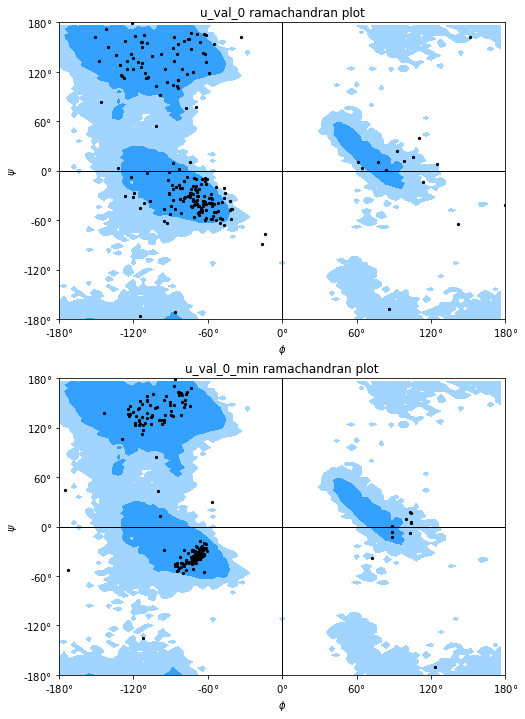

In [85]:
# Here we check that the phi=psi constraints really worked. After minimization 
# the ramachandran plot should show phi-psi angles clustered around the centroids
# To select a range of frames in a trajectory 
# use .run(startframe,endframe+1)

# Ramachandran angles in the reference protein. 
u_val_0 = mda.Universe('u_val_0.pdb','u_val_0.pdb')
u_val_0_protein = u_val_0.select_atoms('protein and not (name H* )')
u_val_0_rama = dihedrals.Ramachandran(u_val_0_protein).run()
plt.figure(figsize=(8, 12)) 
plt.subplot(2,1,1)
u_val_0_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0 ramachandran plot') 
u_val_0_phipsi_obs_radians = u_val_0_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_phipsi.shape}')
# print(u_val_0_phipsi_radians.shape)
# print(u_val_0_phipsi_radians[0][:6])

# Ramachandran angles in the minimized reference protein. 
u_val_0_min = mda.Universe('u_val_0_min.pdb','u_val_0_min.pdb')
u_val_0_min_protein = u_val_0_min.select_atoms('protein and not (name H* )')
u_val_0_min_rama = dihedrals.Ramachandran(u_val_0_min_protein).run()
plt.subplot(2,1,2)
u_val_0_min_rama.plot(color='black', marker='.', s=20, ref=True)
plt.title('u_val_0_min ramachandran plot')          
u_val_0_min_phipsi_radians = u_val_0_min_rama.results.angles * deg_to_rad
# print(f'Ramachandran angles array shape: {u_val_0_min_phipsi.shape}')
# print(u_val_0_min_phipsi_radians.shape)
# print(u_val_0_min_phipsi_radians[0][:6])

#### Comparison of initial and phi-psi constrained minimized structures

In [86]:
# Backbone rmsd between the structures
RMSD = rms.rmsd(u_val_0_min.select_atoms('backbone and not(name H*)').positions,  # coordinates to align
         u_val_0.select_atoms('backbone and not(name H*)').positions,  # reference coordinates
         center=True,  # subtract the center of geometry
         superposition=True)  # superimpose coordinates
print(f'RMSD[backbone] (u_val_0_min vs. u_val_0): {RMSD:.3f}')

# Superposition before and after minimization
rmsds = align.alignto(u_val_0_min,  # minimized
                      u_val_0,  # reference
                      select='name CA', # selection to operate on
                      match_atoms=True) # whether to match atoms
print(rmsds)
nv.show_mdanalysis(mda.Merge(u_val_0_min.atoms, u_val_0.atoms))

RMSD[backbone] (u_val_0_min vs. u_val_0): 0.444
(0.654127092617752, 0.3867429096028172)


NGLWidget()

#### View the extended trajectory 

In [87]:
# Select frames to view from the extension array 
extended_list = []
ext_frame_numbers = np.arange(0,n_extensions,10)
sequence = prot_sequence_slc + '*'

for ext_frame_number_ind,ext_frame_number in enumerate(ext_frame_numbers):
    
    # Modeller environment
    log.level(output=0, notes=0, warnings=0, errors=0, memory=0)
    env = Environ()
    env.io.atom_files_directory = '.'
    env.edat.dynamic_sphere = True

    env.libs.topology.read(file='$(LIB)/top_heav.lib')
    env.libs.parameters.read(file='$(LIB)/par.lib')

    if ext_frame_number == 0:
        # here we choose the minimized structure selected for extension
        code = 'u_val_0_min'                
    else:
        # here we choose the previous extended frame as the start frame 
        code = 'u_val_extension_' + str(ext_frame_numbers[ext_frame_number_ind-1])
        
    ali_code = code + '.pdb'
    with open("alignment_min.ali", "w") as text_file:
        print(f'>P1;orig\nstructureX:{ali_code}:1:A:{n_res}:A::::\n{sequence}',file=text_file)
        print(f'>P1;seq\nsequence::1:A:{n_res}:A::::\n{sequence}',file=text_file)        
        
    mdl = complete_pdb(env, code + '.pdb')       
    
    rsr = mdl.restraints

    # Select all atoms:
    atmsel = Selection(mdl)    

    # Generate static restraints:
    rsr.make(atmsel, restraint_type='stereo', spline_on_site=False)

    # Example of phi and phi angles atoms definition
    # 2 ARG PHI:  (1 MET C)-(2 ARG N)-(2 ARG CA)-(2 ARG C)  
    # 2 ARG PSI:  (2 ARG N)-(2 ARG CA)-(2 ARG C)-(3 ILE N) 

    # Add dynamic restraints on the phi-psi dihedrals
    for i in range(2,214): 
        phi_1 = mdl.atoms['C:'+str(i-1)+':A']
        phi_2 = mdl.atoms['N:'+str(i)+':A']
        phi_3 = mdl.atoms['CA:'+str(i)+':A']
        phi_4 = mdl.atoms['C:'+str(i)+':A']    
        psi_1 = mdl.atoms['N:'+str(i)+':A']
        psi_2 = mdl.atoms['CA:'+str(i)+':A']
        psi_3 = mdl.atoms['C:'+str(i)+':A']
        psi_4 = mdl.atoms['N:'+str(i+1)+':A']
        
        # Binormal constraints
        rsr.add(forms.MultiBinormal(group=physical.phi_psi_dihedral,
                               features=[features.Dihedral(phi_1, phi_2, phi_3, phi_4),
                                         features.Dihedral(psi_1, psi_2, psi_3, psi_4)],
                               weights=[100,100],
                               means=[extended_trj_phipsi[ext_frame_number][i-2,:].tolist(),
                                      extended_trj_phipsi[ext_frame_number][i-2,:].tolist()],
                               stdevs=[[0.1,0.1],[0.1,0.1]],
                               correls=[0.5,0.5]))    
 
    mdl.restraints.write(file = code + '.rsr')

    # Addition of restraints to the default ones
    class RestrainModel(AutoModel):
        def special_restraints(self, aln):
            rsr = self.restraints
            # Add restraints from file:
            rsr.append(file = code + '.rsr')          

    a = RestrainModel(env,
                alnfile  = 'alignment_min.ali',     # alignment filename
                knowns   = 'orig',              # codes of the templates
                sequence = 'seq',
                )              # code of the target
    a.starting_model= 1                 # index of the first model
    a.ending_model  = 1                 # index of the last model
                                        # (determines how many models to calculate)
    a.make()                            # do comparative modeling
    
    a.write(file='u_val_extension_' + str(ext_frame_number) + '.pdb')   

    extended_list.append('u_val_extension_' + str(ext_frame_number) + '.pdb')    


0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2126.48608

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename                          molpdf
----------------------------------------
seq.B99990001.pdb             2266.38208

0 atoms in HETATM/BLK residues constrained
to protein atoms within 2.30 angstroms
and protein CA atoms within 10.00 angstroms
0 atoms in residues without defined topology
constrained to be rigid bodies

>> Summary of successfully produced models:
Filename   

In [88]:
# Check extended list
extended_list = extended_list[:len(ext_frame_numbers)]
print(extended_list)

['u_val_extension_0.pdb', 'u_val_extension_10.pdb', 'u_val_extension_20.pdb', 'u_val_extension_30.pdb', 'u_val_extension_40.pdb', 'u_val_extension_50.pdb', 'u_val_extension_60.pdb', 'u_val_extension_70.pdb', 'u_val_extension_80.pdb', 'u_val_extension_90.pdb']


In [89]:
# If reverse is True the displayed trj will goes back and forth
reverse = True

if reverse:
    extended_list.append(extended_list[::-1])

# ife tag as input_frame_early    
u_val_ext_trj_ex3 = mda.Universe('u_val_0_min.pdb',extended_list)

# Fit in place extended trj to the reference structure
alignment_ex3 = align.AlignTraj(u_val_ext_trj_ex3, u_val_0_min, in_memory=True)
alignment_ex3.run()

view_u_val_ext_trj_ex3 = nv.show_mdanalysis(u_val_ext_trj_ex3)

view_u_val_ext_trj_ex3.center()
view_u_val_ext_trj_ex3


NGLWidget(max_frame=19)